In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 190)
(2, 190)


[I 2025-06-06 23:05:12,492] A new study created in memory with name: no-name-bb30f0a7-8c26-4230-bde6-fde1fa158ebd
[I 2025-06-06 23:07:03,304] Trial 0 finished with value: 0.14671363979578017 and parameters: {'lr': 0.0022349663455481913, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.431176803609304}. Best is trial 0 with value: 0.14671363979578017.


Cross Validation Accuracies:
[0.14171338081359863, 0.11892141401767731, 0.09974900633096695, 0.26247817277908325, 0.11070622503757477]
Mean Cross Validation Accuracy:
0.14671363979578017
Standard Deviation of Cross Validation Accuracy:
0.05949966086371566


[I 2025-06-06 23:10:13,974] Trial 1 finished with value: 27.780299758911134 and parameters: {'lr': 0.2961124004060797, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4941335141207085}. Best is trial 0 with value: 0.14671363979578017.


Cross Validation Accuracies:
[26.18029022216797, 18.253095626831055, 34.7186164855957, 30.729482650756836, 29.0200138092041]
Mean Cross Validation Accuracy:
27.780299758911134
Standard Deviation of Cross Validation Accuracy:
5.508220379538801


[I 2025-06-06 23:12:50,114] Trial 2 finished with value: 0.10349755585193635 and parameters: {'lr': 0.29460726967224193, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2359016488295847}. Best is trial 2 with value: 0.10349755585193635.


Cross Validation Accuracies:
[0.09951695054769516, 0.10578691959381104, 0.09620798379182816, 0.12274149060249329, 0.09323443472385406]
Mean Cross Validation Accuracy:
0.10349755585193635
Standard Deviation of Cross Validation Accuracy:
0.010486991424843023


[I 2025-06-06 23:16:27,517] Trial 3 finished with value: 0.11549542248249053 and parameters: {'lr': 0.3082669039421193, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32596459447245124}. Best is trial 2 with value: 0.10349755585193635.


Cross Validation Accuracies:
[0.12979905307292938, 0.1317259818315506, 0.1069481149315834, 0.11306542158126831, 0.095938540995121]
Mean Cross Validation Accuracy:
0.11549542248249053
Standard Deviation of Cross Validation Accuracy:
0.013634206167664115


[I 2025-06-06 23:20:29,342] Trial 4 finished with value: 0.1294120505452156 and parameters: {'lr': 0.17581044600493476, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4709821848704355}. Best is trial 2 with value: 0.10349755585193635.


Cross Validation Accuracies:
[0.1406681090593338, 0.13150428235530853, 0.11306696385145187, 0.1360301673412323, 0.12579073011875153]
Mean Cross Validation Accuracy:
0.1294120505452156
Standard Deviation of Cross Validation Accuracy:
0.009540980848989414


[I 2025-06-06 23:23:47,458] Trial 5 finished with value: 0.1057751476764679 and parameters: {'lr': 0.006716871157709721, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2483643090410071}. Best is trial 2 with value: 0.10349755585193635.


Cross Validation Accuracies:
[0.09513766318559647, 0.1413867175579071, 0.08465048670768738, 0.12559771537780762, 0.08210315555334091]
Mean Cross Validation Accuracy:
0.1057751476764679
Standard Deviation of Cross Validation Accuracy:
0.023583420821041465


[I 2025-06-06 23:26:55,939] Trial 6 finished with value: 0.08897823542356491 and parameters: {'lr': 0.00848238641519745, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30494289973296695}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.08053014427423477, 0.09262672066688538, 0.08975160866975784, 0.11627355217933655, 0.06570915132761002]
Mean Cross Validation Accuracy:
0.08897823542356491
Standard Deviation of Cross Validation Accuracy:
0.016563600974900193


[I 2025-06-06 23:29:53,682] Trial 7 finished with value: 0.10595468431711197 and parameters: {'lr': 0.7200882391032746, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15609912896759673}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.0921093001961708, 0.17403066158294678, 0.08563670516014099, 0.1053868904709816, 0.07260986417531967]
Mean Cross Validation Accuracy:
0.10595468431711197
Standard Deviation of Cross Validation Accuracy:
0.035640014139498195


[I 2025-06-06 23:33:58,555] Trial 8 finished with value: 0.12604380398988724 and parameters: {'lr': 0.009373056664065769, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18959265938425007}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.13218654692173004, 0.09927577525377274, 0.10188286006450653, 0.20051243901252747, 0.09636139869689941]
Mean Cross Validation Accuracy:
0.12604380398988724
Standard Deviation of Cross Validation Accuracy:
0.03940719388797415


[I 2025-06-06 23:37:20,429] Trial 9 finished with value: 0.0932745948433876 and parameters: {'lr': 0.019847335563242967, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.235735244980024}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.10093896836042404, 0.09246059507131577, 0.08976293355226517, 0.10480091720819473, 0.07840956002473831]
Mean Cross Validation Accuracy:
0.0932745948433876
Standard Deviation of Cross Validation Accuracy:
0.009225641977426384


[I 2025-06-06 23:41:00,930] Trial 10 finished with value: 0.10401313602924347 and parameters: {'lr': 0.0538105529055451, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.36786816468417594}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.09217887371778488, 0.14848898351192474, 0.08347742259502411, 0.10495955497026443, 0.09096084535121918]
Mean Cross Validation Accuracy:
0.10401313602924347
Standard Deviation of Cross Validation Accuracy:
0.023285722238174517


[I 2025-06-06 23:44:17,495] Trial 11 finished with value: 0.0890108585357666 and parameters: {'lr': 0.024924416727447416, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11125427427126713}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.09304093569517136, 0.09215991944074631, 0.08311214298009872, 0.10493036359548569, 0.07181093096733093]
Mean Cross Validation Accuracy:
0.0890108585357666
Standard Deviation of Cross Validation Accuracy:
0.011047362593909558


[I 2025-06-06 23:47:05,444] Trial 12 finished with value: 0.15403104275465013 and parameters: {'lr': 0.0016332766294699878, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10269014894985345}. Best is trial 6 with value: 0.08897823542356491.


Cross Validation Accuracies:
[0.2527667284011841, 0.20129188895225525, 0.11519047617912292, 0.12641790509223938, 0.07448821514844894]
Mean Cross Validation Accuracy:
0.15403104275465013
Standard Deviation of Cross Validation Accuracy:
0.06415677611985487


[I 2025-06-06 23:49:44,296] Trial 13 finished with value: 0.08891680985689163 and parameters: {'lr': 0.043429944644347844, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3619815025466768}. Best is trial 13 with value: 0.08891680985689163.


Cross Validation Accuracies:
[0.09257069230079651, 0.09225090593099594, 0.08290310949087143, 0.1050415188074112, 0.07181782275438309]
Mean Cross Validation Accuracy:
0.08891680985689163
Standard Deviation of Cross Validation Accuracy:
0.011072608042446232


[I 2025-06-06 23:53:01,941] Trial 14 finished with value: 0.15697832107543946 and parameters: {'lr': 0.06698267338449361, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.36232135245032027}. Best is trial 13 with value: 0.08891680985689163.


Cross Validation Accuracies:
[0.1441497802734375, 0.1378045529127121, 0.19655388593673706, 0.14232204854488373, 0.16406133770942688]
Mean Cross Validation Accuracy:
0.15697832107543946
Standard Deviation of Cross Validation Accuracy:
0.021741231004175843


[I 2025-06-06 23:56:09,681] Trial 15 finished with value: 0.0951899915933609 and parameters: {'lr': 0.006767038146393068, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2959723570849587}. Best is trial 13 with value: 0.08891680985689163.


Cross Validation Accuracies:
[0.09719568490982056, 0.09618186205625534, 0.08852478861808777, 0.10508440434932709, 0.08896321803331375]
Mean Cross Validation Accuracy:
0.0951899915933609
Standard Deviation of Cross Validation Accuracy:
0.006100879545606057


[I 2025-06-06 23:58:52,333] Trial 16 finished with value: 0.2046358108520508 and parameters: {'lr': 0.08462788911100314, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.40541553687528503}. Best is trial 13 with value: 0.08891680985689163.


Cross Validation Accuracies:
[0.27260154485702515, 0.23822572827339172, 0.2210027128458023, 0.16189895570278168, 0.12945011258125305]
Mean Cross Validation Accuracy:
0.2046358108520508
Standard Deviation of Cross Validation Accuracy:
0.051951567915891714


[I 2025-06-07 00:01:49,021] Trial 17 finished with value: 0.09097509235143661 and parameters: {'lr': 0.003275498915529479, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2876916407501598}. Best is trial 13 with value: 0.08891680985689163.


Cross Validation Accuracies:
[0.0927966833114624, 0.09256935119628906, 0.08322791755199432, 0.11321667581796646, 0.07306483387947083]
Mean Cross Validation Accuracy:
0.09097509235143661
Standard Deviation of Cross Validation Accuracy:
0.013276625820549346


[I 2025-06-07 00:04:56,766] Trial 18 finished with value: 0.08838474750518799 and parameters: {'lr': 0.012436281156452835, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3465115243423581}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09225284308195114, 0.09201015532016754, 0.0810689628124237, 0.1037568673491478, 0.07283490896224976]
Mean Cross Validation Accuracy:
0.08838474750518799
Standard Deviation of Cross Validation Accuracy:
0.010580415852841361


[I 2025-06-07 00:07:53,161] Trial 19 finished with value: 0.08975785672664642 and parameters: {'lr': 0.016747082354856613, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3964742083402837}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.0930919274687767, 0.09345394372940063, 0.0844307541847229, 0.10501966625452042, 0.07279299199581146]
Mean Cross Validation Accuracy:
0.08975785672664642
Standard Deviation of Cross Validation Accuracy:
0.010713398841994628


[I 2025-06-07 00:10:55,676] Trial 20 finished with value: 0.09286824017763137 and parameters: {'lr': 0.042854849515663596, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.34589357771407164}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.11289602518081665, 0.0914931446313858, 0.0834893137216568, 0.10461583733558655, 0.07184688001871109]
Mean Cross Validation Accuracy:
0.09286824017763137
Standard Deviation of Cross Validation Accuracy:
0.014634691272987858


[I 2025-06-07 00:13:55,087] Trial 21 finished with value: 0.08862875998020173 and parameters: {'lr': 0.015062088478478293, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.317199213083863}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09168053418397903, 0.09032788872718811, 0.08411599695682526, 0.10536017268896103, 0.07165920734405518]
Mean Cross Validation Accuracy:
0.08862875998020173
Standard Deviation of Cross Validation Accuracy:
0.010958752504702447


[I 2025-06-07 00:16:51,090] Trial 22 finished with value: 0.09103487879037857 and parameters: {'lr': 0.013674842605252239, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.43106771363534147}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09147458523511887, 0.09474874287843704, 0.08572117984294891, 0.1115681454539299, 0.07166174054145813]
Mean Cross Validation Accuracy:
0.09103487879037857
Standard Deviation of Cross Validation Accuracy:
0.012954960827531082


[I 2025-06-07 00:19:43,379] Trial 23 finished with value: 0.09396390467882157 and parameters: {'lr': 0.003957314368564959, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26614646050713103}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.10624050348997116, 0.08690878003835678, 0.0961613804101944, 0.10633598268032074, 0.07417287677526474]
Mean Cross Validation Accuracy:
0.09396390467882157
Standard Deviation of Cross Validation Accuracy:
0.012248033811244402


[I 2025-06-07 00:22:34,539] Trial 24 finished with value: 0.08957323729991913 and parameters: {'lr': 0.03544913345243294, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33630827134323726}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09244897961616516, 0.09181475639343262, 0.08416910469532013, 0.10659412294626236, 0.07283922284841537]
Mean Cross Validation Accuracy:
0.08957323729991913
Standard Deviation of Cross Validation Accuracy:
0.011065592968957


[I 2025-06-07 00:25:17,727] Trial 25 finished with value: 0.09172828793525696 and parameters: {'lr': 0.0010506584308861801, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.38987193787729363}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09467872232198715, 0.09709280729293823, 0.08573123067617416, 0.10555389523506165, 0.0755847841501236]
Mean Cross Validation Accuracy:
0.09172828793525696
Standard Deviation of Cross Validation Accuracy:
0.010248980031662493


[I 2025-06-07 00:28:24,044] Trial 26 finished with value: 0.21389234066009521 and parameters: {'lr': 0.10145066220555451, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.32052891075033996}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.15099294483661652, 0.19942516088485718, 0.22560907900333405, 0.215458482503891, 0.27797603607177734]
Mean Cross Validation Accuracy:
0.21389234066009521
Standard Deviation of Cross Validation Accuracy:
0.04101728431016311


[I 2025-06-07 00:31:27,112] Trial 27 finished with value: 0.08857558071613311 and parameters: {'lr': 0.029311512084669034, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4375622337694432}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09219183772802353, 0.09760686755180359, 0.08526100218296051, 0.09638169407844543, 0.07143650203943253]
Mean Cross Validation Accuracy:
0.08857558071613311
Standard Deviation of Cross Validation Accuracy:
0.009594908141802857


[I 2025-06-07 00:35:56,484] Trial 28 finished with value: 0.11861003786325455 and parameters: {'lr': 0.011806994117201548, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4547908364742934}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.16882744431495667, 0.09201780706644058, 0.10138954222202301, 0.14684762060642242, 0.08396777510643005]
Mean Cross Validation Accuracy:
0.11861003786325455
Standard Deviation of Cross Validation Accuracy:
0.03323530522714142


[I 2025-06-07 00:39:09,654] Trial 29 finished with value: 0.11618992984294892 and parameters: {'lr': 0.004642678831713296, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.42925187122730113}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.13798591494560242, 0.10817365348339081, 0.11757849901914597, 0.1381659209728241, 0.07904566079378128]
Mean Cross Validation Accuracy:
0.11618992984294892
Standard Deviation of Cross Validation Accuracy:
0.02192667182662382


[I 2025-06-07 00:42:29,987] Trial 30 finished with value: 2.5299775123596193 and parameters: {'lr': 0.0313695924731879, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20050150419498552}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[2.7400929927825928, 2.796006202697754, 2.789468765258789, 1.6967625617980957, 2.6275570392608643]
Mean Cross Validation Accuracy:
2.5299775123596193
Standard Deviation of Cross Validation Accuracy:
0.4209571017187129


[I 2025-06-07 00:45:20,888] Trial 31 finished with value: 0.08888499587774276 and parameters: {'lr': 0.02755799800104247, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.38691291945506423}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09457401186227798, 0.08977258205413818, 0.08303400129079819, 0.10470739752054214, 0.07233698666095734]
Mean Cross Validation Accuracy:
0.08888499587774276
Standard Deviation of Cross Validation Accuracy:
0.010877240941839582


[I 2025-06-07 00:48:25,915] Trial 32 finished with value: 0.08902257829904556 and parameters: {'lr': 0.019617125912770726, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.49628516796133637}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09134884923696518, 0.09296698868274689, 0.08254445344209671, 0.10613971203565598, 0.07211288809776306]
Mean Cross Validation Accuracy:
0.08902257829904556
Standard Deviation of Cross Validation Accuracy:
0.011330224194377044


[I 2025-06-07 00:51:53,930] Trial 33 finished with value: 0.08892916887998581 and parameters: {'lr': 0.026927260393083234, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.41190167793620114}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.0918678343296051, 0.09232770651578903, 0.08294373750686646, 0.10491515696048737, 0.07259140908718109]
Mean Cross Validation Accuracy:
0.08892916887998581
Standard Deviation of Cross Validation Accuracy:
0.01075625781920834


[I 2025-06-07 00:55:01,571] Trial 34 finished with value: 0.09055875539779663 and parameters: {'lr': 0.01195141628074897, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4527999946888549}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.08843080699443817, 0.09549866616725922, 0.09013702720403671, 0.1066678985953331, 0.07205937802791595]
Mean Cross Validation Accuracy:
0.09055875539779663
Standard Deviation of Cross Validation Accuracy:
0.011232454719419162


[I 2025-06-07 00:58:52,868] Trial 35 finished with value: 0.09972434192895889 and parameters: {'lr': 0.1385964428438617, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.37164551904433774}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09599896520376205, 0.10148210823535919, 0.08687683194875717, 0.11514711380004883, 0.09911669045686722]
Mean Cross Validation Accuracy:
0.09972434192895889
Standard Deviation of Cross Validation Accuracy:
0.009167963997782228


[I 2025-06-07 01:02:18,981] Trial 36 finished with value: 0.1318279981613159 and parameters: {'lr': 0.0058895973022716356, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3181090519249749}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.15576276183128357, 0.11301231384277344, 0.18312880396842957, 0.10636774450540543, 0.10086836665868759]
Mean Cross Validation Accuracy:
0.1318279981613159
Standard Deviation of Cross Validation Accuracy:
0.032141558343593966


[I 2025-06-07 01:05:35,776] Trial 37 finished with value: 0.09677378684282303 and parameters: {'lr': 0.002781544930187996, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4577349708634269}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09899117797613144, 0.09621082991361618, 0.08515210449695587, 0.11338107287883759, 0.09013374894857407]
Mean Cross Validation Accuracy:
0.09677378684282303
Standard Deviation of Cross Validation Accuracy:
0.009593636403465824


[I 2025-06-07 01:10:14,033] Trial 38 finished with value: 0.11028067171573638 and parameters: {'lr': 0.02226834084460397, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27844522809516375}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.10908525437116623, 0.10744449496269226, 0.09482020884752274, 0.14194907248020172, 0.098104327917099]
Mean Cross Validation Accuracy:
0.11028067171573638
Standard Deviation of Cross Validation Accuracy:
0.0167311074862546


[I 2025-06-07 01:13:29,610] Trial 39 finished with value: 0.5555080235004425 and parameters: {'lr': 0.2181465533933086, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3848735275078942}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.7212156057357788, 0.4632321298122406, 0.5324727296829224, 0.5589231848716736, 0.5016964673995972]
Mean Cross Validation Accuracy:
0.5555080235004425
Standard Deviation of Cross Validation Accuracy:
0.08878267288686745


[I 2025-06-07 01:16:33,044] Trial 40 finished with value: 0.5956371068954468 and parameters: {'lr': 0.009383858727551294, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.48157597066167346}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.6661373376846313, 0.580988883972168, 0.5981391072273254, 0.5794039368629456, 0.5535162687301636]
Mean Cross Validation Accuracy:
0.5956371068954468
Standard Deviation of Cross Validation Accuracy:
0.038023134533726057


[I 2025-06-07 01:19:39,898] Trial 41 finished with value: 0.09396677613258361 and parameters: {'lr': 0.045752157778889524, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4173262042995588}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09225532412528992, 0.10678144544363022, 0.08480112999677658, 0.1049870103597641, 0.08100897073745728]
Mean Cross Validation Accuracy:
0.09396677613258361
Standard Deviation of Cross Validation Accuracy:
0.010397155088691034


[I 2025-06-07 01:22:49,201] Trial 42 finished with value: 0.13226278424263 and parameters: {'lr': 0.06362133678960627, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3429213780234609}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.10538749396800995, 0.13900543749332428, 0.15699905157089233, 0.12940581142902374, 0.13051612675189972]
Mean Cross Validation Accuracy:
0.13226278424263
Standard Deviation of Cross Validation Accuracy:
0.016678372987717075


[I 2025-06-07 01:26:30,546] Trial 43 finished with value: 0.08858887255191802 and parameters: {'lr': 0.015779281810963258, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3487874576202394}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.08936326950788498, 0.09169941395521164, 0.08433040976524353, 0.10571247339248657, 0.07183879613876343]
Mean Cross Validation Accuracy:
0.08858887255191802
Standard Deviation of Cross Validation Accuracy:
0.010974446950677234


[I 2025-06-07 01:29:57,892] Trial 44 finished with value: 0.1082382157444954 and parameters: {'lr': 0.014672893216441016, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3087960296092347}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.0959591194987297, 0.17399930953979492, 0.08206059783697128, 0.11593390256166458, 0.07323814928531647]
Mean Cross Validation Accuracy:
0.1082382157444954
Standard Deviation of Cross Validation Accuracy:
0.035902071218285384


[I 2025-06-07 01:33:17,660] Trial 45 finished with value: 0.08904604464769364 and parameters: {'lr': 0.03156731502603416, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.38120031874274607}. Best is trial 18 with value: 0.08838474750518799.


Cross Validation Accuracies:
[0.09203284233808517, 0.09225242584943771, 0.08418017625808716, 0.10463789850473404, 0.07212688028812408]
Mean Cross Validation Accuracy:
0.08904604464769364
Standard Deviation of Cross Validation Accuracy:
0.010698060995943441


[I 2025-06-07 01:37:48,433] Trial 46 finished with value: 0.08819646686315537 and parameters: {'lr': 0.008321144937286444, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3496111553348004}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.08985748142004013, 0.09396443516016006, 0.08126720041036606, 0.10567677021026611, 0.07021644711494446]
Mean Cross Validation Accuracy:
0.08819646686315537
Standard Deviation of Cross Validation Accuracy:
0.011940563441146745


[I 2025-06-07 01:42:16,260] Trial 47 finished with value: 0.08874409794807434 and parameters: {'lr': 0.008429853993711748, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24111095572586838}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09141933917999268, 0.09168892353773117, 0.08427181094884872, 0.10569283366203308, 0.07064758241176605]
Mean Cross Validation Accuracy:
0.08874409794807434
Standard Deviation of Cross Validation Accuracy:
0.01140678553549039


[I 2025-06-07 01:46:22,463] Trial 48 finished with value: 0.08906642496585845 and parameters: {'lr': 0.005533846028750049, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3506552890768729}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09210914373397827, 0.09232676029205322, 0.08365783095359802, 0.10494393110275269, 0.0722944587469101]
Mean Cross Validation Accuracy:
0.08906642496585845
Standard Deviation of Cross Validation Accuracy:
0.010793839586608841


[I 2025-06-07 01:51:03,232] Trial 49 finished with value: 0.10260652005672455 and parameters: {'lr': 0.008381036698939425, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3308028399689559}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.10896353423595428, 0.10322938114404678, 0.09605944901704788, 0.12737804651260376, 0.07740218937397003]
Mean Cross Validation Accuracy:
0.10260652005672455
Standard Deviation of Cross Validation Accuracy:
0.01632513725839734


[I 2025-06-07 01:55:47,268] Trial 50 finished with value: 1.931302833557129 and parameters: {'lr': 0.6020936694730064, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2697407302466513}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[1.2736661434173584, 3.495168685913086, 1.106408953666687, 2.1749274730682373, 1.6063429117202759]
Mean Cross Validation Accuracy:
1.931302833557129
Standard Deviation of Cross Validation Accuracy:
0.8629674674332579


[I 2025-06-07 01:59:59,223] Trial 51 finished with value: 0.09001372903585433 and parameters: {'lr': 0.008175160137304552, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23739121882852232}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09529293328523636, 0.09588678181171417, 0.08231884986162186, 0.1059056967496872, 0.07066438347101212]
Mean Cross Validation Accuracy:
0.09001372903585433
Standard Deviation of Cross Validation Accuracy:
0.012235405375597084


[I 2025-06-07 02:04:11,268] Trial 52 finished with value: 0.08945312947034836 and parameters: {'lr': 0.017118089797380484, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.25494533349517745}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09210926294326782, 0.0919482409954071, 0.08290970325469971, 0.10809756815433502, 0.07220087200403214]
Mean Cross Validation Accuracy:
0.08945312947034836
Standard Deviation of Cross Validation Accuracy:
0.011843585054476406


[I 2025-06-07 02:08:36,500] Trial 53 finished with value: 0.08912171870470047 and parameters: {'lr': 0.011179847495095176, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21666393980359647}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09216640144586563, 0.09285283088684082, 0.08394503593444824, 0.10479221493005753, 0.07185211032629013]
Mean Cross Validation Accuracy:
0.08912171870470047
Standard Deviation of Cross Validation Accuracy:
0.01089764342513079


[I 2025-06-07 02:13:08,164] Trial 54 finished with value: 0.09160611182451248 and parameters: {'lr': 0.0067882555872370316, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15688410377200626}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.0875992476940155, 0.10393870621919632, 0.08531314134597778, 0.10785750299692154, 0.07332196086645126]
Mean Cross Validation Accuracy:
0.09160611182451248
Standard Deviation of Cross Validation Accuracy:
0.012697773138653766


[I 2025-06-07 02:17:38,359] Trial 55 finished with value: 0.09460089802742004 and parameters: {'lr': 0.002113224363279374, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2960858594964152}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09482736885547638, 0.09451133757829666, 0.09964288026094437, 0.10941074788570404, 0.07461215555667877]
Mean Cross Validation Accuracy:
0.09460089802742004
Standard Deviation of Cross Validation Accuracy:
0.011352201313751559


[I 2025-06-07 02:20:53,488] Trial 56 finished with value: 0.09019217491149903 and parameters: {'lr': 0.020665785888423768, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3089213119123116}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09265480935573578, 0.09159718453884125, 0.08551862090826035, 0.10729638487100601, 0.07389387488365173]
Mean Cross Validation Accuracy:
0.09019217491149903
Standard Deviation of Cross Validation Accuracy:
0.010844992481478988


[I 2025-06-07 02:25:20,273] Trial 57 finished with value: 0.09536426514387131 and parameters: {'lr': 0.004654441716070493, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.36244813170387513}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.10757795721292496, 0.08699549734592438, 0.0977451503276825, 0.1055692732334137, 0.07893344759941101]
Mean Cross Validation Accuracy:
0.09536426514387131
Standard Deviation of Cross Validation Accuracy:
0.010945255757259206


[I 2025-06-07 02:29:46,472] Trial 58 finished with value: 0.08907316774129867 and parameters: {'lr': 0.014197093168942253, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2829342107784816}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09192300587892532, 0.09237522631883621, 0.08364591002464294, 0.1051938459277153, 0.0722278505563736]
Mean Cross Validation Accuracy:
0.08907316774129867
Standard Deviation of Cross Validation Accuracy:
0.010882290851046951


[I 2025-06-07 02:33:23,909] Trial 59 finished with value: 0.09712921231985092 and parameters: {'lr': 0.009968396186548462, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3557565680483961}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.10808831453323364, 0.0979883074760437, 0.09312918037176132, 0.10759283602237701, 0.07884742319583893]
Mean Cross Validation Accuracy:
0.09712921231985092
Standard Deviation of Cross Validation Accuracy:
0.010775448537851317


[I 2025-06-07 02:37:03,755] Trial 60 finished with value: 0.364209920167923 and parameters: {'lr': 0.016877379598573303, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33358442808460914}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.4041878879070282, 0.3798632323741913, 0.36714428663253784, 0.33449169993400574, 0.3353624939918518]
Mean Cross Validation Accuracy:
0.364209920167923
Standard Deviation of Cross Validation Accuracy:
0.026710377028338582


[I 2025-06-07 02:40:02,162] Trial 61 finished with value: 0.08962115347385406 and parameters: {'lr': 0.02524070080127784, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3916966999481802}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09250842779874802, 0.0921359658241272, 0.0836530476808548, 0.10547330975532532, 0.074335016310215]
Mean Cross Validation Accuracy:
0.08962115347385406
Standard Deviation of Cross Validation Accuracy:
0.010346359447636502


[I 2025-06-07 02:43:18,632] Trial 62 finished with value: 0.08920046091079711 and parameters: {'lr': 0.040434134360803765, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.37520362387744927}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.089971624314785, 0.09279869496822357, 0.08579202741384506, 0.10586274415254593, 0.07157721370458603]
Mean Cross Validation Accuracy:
0.08920046091079711
Standard Deviation of Cross Validation Accuracy:
0.011075828864245862


[I 2025-06-07 02:46:40,860] Trial 63 finished with value: 0.0893319934606552 and parameters: {'lr': 0.02840271158906982, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3210395953905375}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09216558933258057, 0.09292846918106079, 0.08352094888687134, 0.10526387393474579, 0.07278108596801758]
Mean Cross Validation Accuracy:
0.0893319934606552
Standard Deviation of Cross Validation Accuracy:
0.010793419258806908


[I 2025-06-07 02:50:05,915] Trial 64 finished with value: 0.09445615410804749 and parameters: {'lr': 0.007532098429677549, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4063238408780984}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09279879927635193, 0.09621813148260117, 0.09052840620279312, 0.10791429132223129, 0.08482114225625992]
Mean Cross Validation Accuracy:
0.09445615410804749
Standard Deviation of Cross Validation Accuracy:
0.007684185104143441


[I 2025-06-07 02:53:13,827] Trial 65 finished with value: 0.12710194587707518 and parameters: {'lr': 0.054189040342595717, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4232867692087888}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.20652714371681213, 0.10390374809503555, 0.12810394167900085, 0.11042964458465576, 0.08654525130987167]
Mean Cross Validation Accuracy:
0.12710194587707518
Standard Deviation of Cross Validation Accuracy:
0.04188157956048388


[I 2025-06-07 02:56:31,689] Trial 66 finished with value: 0.09188875705003738 and parameters: {'lr': 0.013087469411466938, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4458662683294229}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09315188974142075, 0.0948546975851059, 0.08501160144805908, 0.10681065917015076, 0.07961493730545044]
Mean Cross Validation Accuracy:
0.09188875705003738
Standard Deviation of Cross Validation Accuracy:
0.00928436740583096


[I 2025-06-07 03:00:03,760] Trial 67 finished with value: 0.0888867124915123 and parameters: {'lr': 0.02098649312752985, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.34164993669350613}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.0925857350230217, 0.09157481789588928, 0.08356981724500656, 0.10499802976846695, 0.071705162525177]
Mean Cross Validation Accuracy:
0.0888867124915123
Standard Deviation of Cross Validation Accuracy:
0.010990525529385245


[I 2025-06-07 03:03:26,005] Trial 68 finished with value: 0.11739022582769394 and parameters: {'lr': 0.0036735762270233723, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3996273483307638}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.13277888298034668, 0.09200882166624069, 0.07230982184410095, 0.16476096212863922, 0.12509264051914215]
Mean Cross Validation Accuracy:
0.11739022582769394
Standard Deviation of Cross Validation Accuracy:
0.032300412131319955


[I 2025-06-07 03:07:31,020] Trial 69 finished with value: 0.08852995187044144 and parameters: {'lr': 0.010685921664290806, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.35488304616534433}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09012942761182785, 0.09317117184400558, 0.08381175249814987, 0.10467630624771118, 0.0708611011505127]
Mean Cross Validation Accuracy:
0.08852995187044144
Standard Deviation of Cross Validation Accuracy:
0.011128824702065273


[I 2025-06-07 03:11:19,172] Trial 70 finished with value: 0.09256039559841156 and parameters: {'lr': 0.005592338642976077, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.30017877475156896}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09538578242063522, 0.09322758764028549, 0.08745352923870087, 0.11521679162979126, 0.07151828706264496]
Mean Cross Validation Accuracy:
0.09256039559841156
Standard Deviation of Cross Validation Accuracy:
0.014075444239480182


[I 2025-06-07 03:15:35,993] Trial 71 finished with value: 0.08920737653970719 and parameters: {'lr': 0.01027652543665701, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.35565313578447943}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09175087511539459, 0.09212400019168854, 0.08478222787380219, 0.10528852045536041, 0.07209125906229019]
Mean Cross Validation Accuracy:
0.08920737653970719
Standard Deviation of Cross Validation Accuracy:
0.0108270280906985


[I 2025-06-07 03:19:10,366] Trial 72 finished with value: 0.08841352611780166 and parameters: {'lr': 0.01592575117773148, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3697903028974226}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09288614988327026, 0.08995133638381958, 0.08233261853456497, 0.10495498031377792, 0.07194254547357559]
Mean Cross Validation Accuracy:
0.08841352611780166
Standard Deviation of Cross Validation Accuracy:
0.010993266767413775


[I 2025-06-07 03:23:10,145] Trial 73 finished with value: 0.0902260571718216 and parameters: {'lr': 0.016830981596224582, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3666429765699489}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09538906067609787, 0.094602569937706, 0.08503178507089615, 0.10569705069065094, 0.07040981948375702]
Mean Cross Validation Accuracy:
0.0902260571718216
Standard Deviation of Cross Validation Accuracy:
0.011872875375435398


[I 2025-06-07 03:27:43,022] Trial 74 finished with value: 0.0896057739853859 and parameters: {'lr': 0.012294827553872272, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3153761688982798}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09236060827970505, 0.0919988602399826, 0.0838267132639885, 0.10484263300895691, 0.07500005513429642]
Mean Cross Validation Accuracy:
0.0896057739853859
Standard Deviation of Cross Validation Accuracy:
0.00992171772118057


[I 2025-06-07 03:32:20,827] Trial 75 finished with value: 0.6220146179199219 and parameters: {'lr': 0.009318978941364185, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.33262926316382346}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.5886533856391907, 0.6729628443717957, 0.663712203502655, 0.582226574420929, 0.6025180816650391]
Mean Cross Validation Accuracy:
0.6220146179199219
Standard Deviation of Cross Validation Accuracy:
0.03849827417618972


[I 2025-06-07 03:36:04,393] Trial 76 finished with value: 0.08857788741588593 and parameters: {'lr': 0.01430646430156569, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4408415557387903}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09257186949253082, 0.08866646140813828, 0.08408761769533157, 0.10523504763841629, 0.07232844084501266]
Mean Cross Validation Accuracy:
0.08857788741588593
Standard Deviation of Cross Validation Accuracy:
0.01074828135920068


[I 2025-06-07 03:39:59,916] Trial 77 finished with value: 0.08937240540981292 and parameters: {'lr': 0.03465880259043235, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4749681699435519}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09220179915428162, 0.09246084094047546, 0.08298133313655853, 0.10518500208854675, 0.07403305172920227]
Mean Cross Validation Accuracy:
0.08937240540981292
Standard Deviation of Cross Validation Accuracy:
0.010428074538028832


[I 2025-06-07 03:43:18,736] Trial 78 finished with value: 0.08933488577604294 and parameters: {'lr': 0.014443071729814646, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.43504556393991967}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09363380074501038, 0.09267043322324753, 0.08316928893327713, 0.1054295003414154, 0.07177140563726425]
Mean Cross Validation Accuracy:
0.08933488577604294
Standard Deviation of Cross Validation Accuracy:
0.011270612970940508


[I 2025-06-07 03:46:45,290] Trial 79 finished with value: 0.08905920237302781 and parameters: {'lr': 0.023105136774504115, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3778534757398571}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09187285602092743, 0.09272561967372894, 0.08385924994945526, 0.10508448630571365, 0.07175379991531372]
Mean Cross Validation Accuracy:
0.08905920237302781
Standard Deviation of Cross Validation Accuracy:
0.010997140057553995


[I 2025-06-07 03:49:17,220] Trial 80 finished with value: 0.09921100735664368 and parameters: {'lr': 0.01809621170924449, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48677731658009793}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.07318288832902908, 0.09003712236881256, 0.09345156699419022, 0.14731596410274506, 0.09206749498844147]
Mean Cross Validation Accuracy:
0.09921100735664368
Standard Deviation of Cross Validation Accuracy:
0.02513925588267571


[I 2025-06-07 03:52:34,565] Trial 81 finished with value: 0.09052538126707077 and parameters: {'lr': 0.007327036455106444, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3441858770524663}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.08737136423587799, 0.09619241207838058, 0.08845183253288269, 0.10856380313634872, 0.07204749435186386]
Mean Cross Validation Accuracy:
0.09052538126707077
Standard Deviation of Cross Validation Accuracy:
0.011943028379667042


[I 2025-06-07 03:55:17,469] Trial 82 finished with value: 0.08891067206859589 and parameters: {'lr': 0.011995750461831453, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4399029149574424}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09314266592264175, 0.0913134217262268, 0.08304847776889801, 0.1054987981915474, 0.07154999673366547]
Mean Cross Validation Accuracy:
0.08891067206859589
Standard Deviation of Cross Validation Accuracy:
0.011265942270943389


[I 2025-06-07 03:58:11,983] Trial 83 finished with value: 0.09590243995189666 and parameters: {'lr': 0.004664598489311185, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32312537131423336}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09139422327280045, 0.09716546535491943, 0.09002884477376938, 0.10978220403194427, 0.0911414623260498]
Mean Cross Validation Accuracy:
0.09590243995189666
Standard Deviation of Cross Validation Accuracy:
0.0073720164132003475


[I 2025-06-07 04:01:07,000] Trial 84 finished with value: 0.09033632129430771 and parameters: {'lr': 0.010215075902359073, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.46184789949306804}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.0940275490283966, 0.09192405641078949, 0.0856495127081871, 0.10346786677837372, 0.07661262154579163]
Mean Cross Validation Accuracy:
0.09033632129430771
Standard Deviation of Cross Validation Accuracy:
0.008931849319099211


[I 2025-06-07 04:04:22,098] Trial 85 finished with value: 0.09059312492609024 and parameters: {'lr': 0.015183182211093603, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16084833050694253}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09126380831003189, 0.09229566156864166, 0.0920921266078949, 0.105400450527668, 0.07191357761621475]
Mean Cross Validation Accuracy:
0.09059312492609024
Standard Deviation of Cross Validation Accuracy:
0.010712402461033619


[I 2025-06-07 04:07:42,693] Trial 86 finished with value: 0.09130926728248596 and parameters: {'lr': 0.005843246697611201, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4146149971885086}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.1033010259270668, 0.09377757459878922, 0.08538845926523209, 0.1058114543557167, 0.068267822265625]
Mean Cross Validation Accuracy:
0.09130926728248596
Standard Deviation of Cross Validation Accuracy:
0.013610087452671133


[I 2025-06-07 04:10:26,641] Trial 87 finished with value: 0.08920897841453553 and parameters: {'lr': 0.019361923479066602, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3538554170561279}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.09264086186885834, 0.09225954115390778, 0.08370758593082428, 0.10536611825227737, 0.07207078486680984]
Mean Cross Validation Accuracy:
0.08920897841453553
Standard Deviation of Cross Validation Accuracy:
0.011010176403186158


[I 2025-06-07 04:12:21,789] Trial 88 finished with value: 0.554542738199234 and parameters: {'lr': 0.008734648501760938, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2898341201408339}. Best is trial 46 with value: 0.08819646686315537.


Cross Validation Accuracies:
[0.6527699828147888, 0.4952833354473114, 0.5028454661369324, 0.5641723275184631, 0.5576425790786743]
Mean Cross Validation Accuracy:
0.554542738199234
Standard Deviation of Cross Validation Accuracy:
0.05645390038234224


[I 2025-06-07 04:14:54,782] Trial 89 finished with value: 0.08809326589107513 and parameters: {'lr': 0.006360634940219467, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3103677591929867}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.08649368584156036, 0.08981925249099731, 0.08637916296720505, 0.10471302270889282, 0.07306120544672012]
Mean Cross Validation Accuracy:
0.08809326589107513
Standard Deviation of Cross Validation Accuracy:
0.010105988252493436


[I 2025-06-07 04:16:56,372] Trial 90 finished with value: 0.08969925194978715 and parameters: {'lr': 0.024598999454199466, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3691234226066331}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09255654364824295, 0.09201063960790634, 0.08724294602870941, 0.10479901731014252, 0.07188711315393448]
Mean Cross Validation Accuracy:
0.08969925194978715
Standard Deviation of Cross Validation Accuracy:
0.010628407876578688


[I 2025-06-07 04:19:30,324] Trial 91 finished with value: 0.0894442617893219 and parameters: {'lr': 0.006374242097427323, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2683071623548018}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09125714004039764, 0.09770844131708145, 0.08168108016252518, 0.10579340904951096, 0.07078123837709427]
Mean Cross Validation Accuracy:
0.0894442617893219
Standard Deviation of Cross Validation Accuracy:
0.012226636813217295


[I 2025-06-07 04:22:15,092] Trial 92 finished with value: 0.08899994641542434 and parameters: {'lr': 0.010972487680829006, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3077159628349702}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09317813813686371, 0.09184630215167999, 0.08301374316215515, 0.10526960343122482, 0.07169194519519806]
Mean Cross Validation Accuracy:
0.08899994641542434
Standard Deviation of Cross Validation Accuracy:
0.011186262128870491


[I 2025-06-07 04:24:38,686] Trial 93 finished with value: 0.0897749662399292 and parameters: {'lr': 0.008233227552784756, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.34004532014889144}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09267128258943558, 0.09321576356887817, 0.08696557581424713, 0.10705665498971939, 0.06896555423736572]
Mean Cross Validation Accuracy:
0.0897749662399292
Standard Deviation of Cross Validation Accuracy:
0.01232727709720433


[I 2025-06-07 04:27:13,374] Trial 94 finished with value: 0.09863538593053818 and parameters: {'lr': 0.0030204647056990786, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3280017070443686}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.10013878345489502, 0.09885212779045105, 0.10629668086767197, 0.11405498534440994, 0.07383435219526291]
Mean Cross Validation Accuracy:
0.09863538593053818
Standard Deviation of Cross Validation Accuracy:
0.013519304284513822


[I 2025-06-07 04:29:40,664] Trial 95 finished with value: 0.08988568186759949 and parameters: {'lr': 0.013273412882960507, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.351123941168022}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09236596524715424, 0.09505946934223175, 0.08361600339412689, 0.10484770685434341, 0.07353926450014114]
Mean Cross Validation Accuracy:
0.08988568186759949
Standard Deviation of Cross Validation Accuracy:
0.01061410668018158


[I 2025-06-07 04:31:55,296] Trial 96 finished with value: 0.08906628340482711 and parameters: {'lr': 0.004835691408751513, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22010277091622096}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.0922817587852478, 0.09205643087625504, 0.08347153663635254, 0.1052679494023323, 0.0722537413239479]
Mean Cross Validation Accuracy:
0.08906628340482711
Standard Deviation of Cross Validation Accuracy:
0.010915466160841554


[I 2025-06-07 04:33:37,633] Trial 97 finished with value: 0.0895420640707016 and parameters: {'lr': 0.01518131786135776, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3611790727314786}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.0920560210943222, 0.09252866357564926, 0.08647111058235168, 0.10551811009645462, 0.07113641500473022]
Mean Cross Validation Accuracy:
0.0895420640707016
Standard Deviation of Cross Validation Accuracy:
0.011123600819912994


[I 2025-06-07 04:35:14,747] Trial 98 finished with value: 0.09094201922416686 and parameters: {'lr': 0.0071758850397279665, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2496429540118608}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09113068878650665, 0.08886513113975525, 0.08901044726371765, 0.10171373188495636, 0.08399009704589844]
Mean Cross Validation Accuracy:
0.09094201922416686
Standard Deviation of Cross Validation Accuracy:
0.005872632223741432


[I 2025-06-07 04:36:56,613] Trial 99 finished with value: 0.10089801996946335 and parameters: {'lr': 0.00929286480633933, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3124600387400555}. Best is trial 89 with value: 0.08809326589107513.


Cross Validation Accuracies:
[0.09160539507865906, 0.0932590663433075, 0.09668292105197906, 0.1455245316028595, 0.07741818577051163]
Mean Cross Validation Accuracy:
0.10089801996946335
Standard Deviation of Cross Validation Accuracy:
0.02326070378696155
Number of finished trials: 100
Best trial: {'lr': 0.006360634940219467, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3103677591929867}
Best hyperparameters:  {'lr': 0.006360634940219467, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3103677591929867}
Fold 1:
Epoch 1/100
19/19 [==============================] - 11s 200ms/step - loss: 0.2928 - val_loss: 0.1934
Epoch 2/100
19/19 [==============================] - 1s 52ms/step - loss: 0.1479 - val_loss: 0.1220
Epoch 3/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1318 - val_loss: 0.1169
Epoch 4/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1294 - val_los

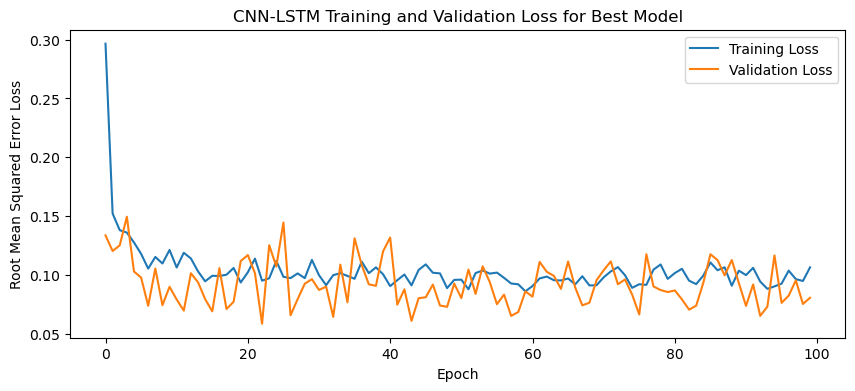

1/1 - 2s - loss: 0.1160 - 2s/epoch - 2s/step
Test Loss: 0.11595690250396729
Fold 3:
Epoch 1/100
19/19 [==============================] - 9s 190ms/step - loss: 0.2787 - val_loss: 0.1682
Epoch 2/100
19/19 [==============================] - 1s 57ms/step - loss: 0.1625 - val_loss: 0.1278
Epoch 3/100
19/19 [==============================] - 1s 58ms/step - loss: 0.1301 - val_loss: 0.1367
Epoch 4/100
19/19 [==============================] - 1s 58ms/step - loss: 0.1260 - val_loss: 0.1496
Epoch 5/100
19/19 [==============================] - 1s 59ms/step - loss: 0.1262 - val_loss: 0.1257
Epoch 6/100
19/19 [==============================] - 1s 58ms/step - loss: 0.1095 - val_loss: 0.1306
Epoch 7/100
19/19 [==============================] - 1s 56ms/step - loss: 0.1188 - val_loss: 0.1217
Epoch 8/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1057 - val_loss: 0.0896
Epoch 9/100
19/19 [==============================] - 1s 57ms/step - loss: 0.1110 - val_loss: 0.0779
Epoch 10/100
19

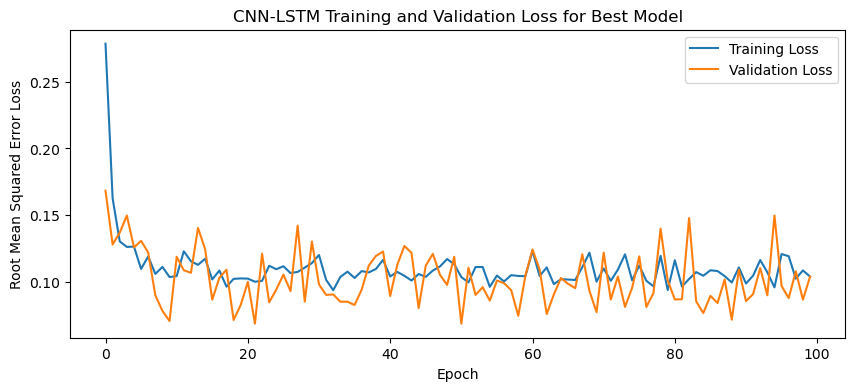

1/1 - 2s - loss: 0.1279 - 2s/epoch - 2s/step
Test Loss: 0.1278889775276184
Fold 4:
Epoch 1/100
20/20 [==============================] - 10s 135ms/step - loss: 0.3246 - val_loss: 0.1913
Epoch 2/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1604 - val_loss: 0.1664
Epoch 3/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1831 - val_loss: 0.1616
Epoch 4/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1701 - val_loss: 0.1322
Epoch 5/100
20/20 [==============================] - 1s 45ms/step - loss: 0.1548 - val_loss: 0.1359
Epoch 6/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1449 - val_loss: 0.1152
Epoch 7/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1458 - val_loss: 0.1172
Epoch 8/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1407 - val_loss: 0.1635
Epoch 9/100
20/20 [==============================] - 1s 45ms/step - loss: 0.1460 - val_loss: 0.1242
Epoch 10/100
20

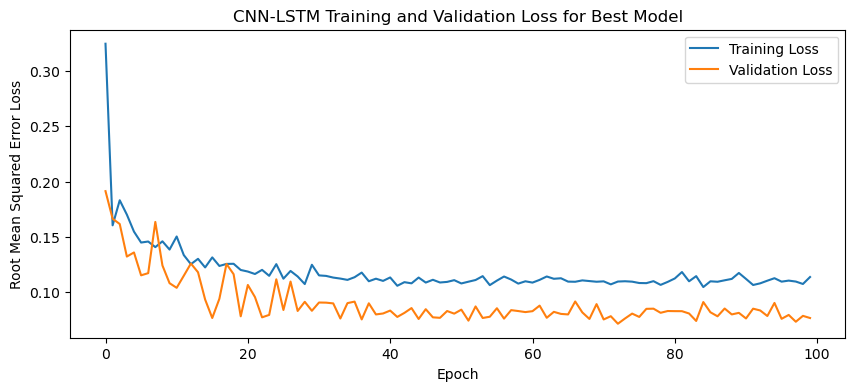

1/1 - 2s - loss: 0.1016 - 2s/epoch - 2s/step
Test Loss: 0.1015569269657135
Fold 5:
Epoch 1/100
19/19 [==============================] - 10s 194ms/step - loss: 0.2694 - val_loss: 0.1956
Epoch 2/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1680 - val_loss: 0.1470
Epoch 3/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1321 - val_loss: 0.1158
Epoch 4/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1186 - val_loss: 0.1660
Epoch 5/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1300 - val_loss: 0.1443
Epoch 6/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1210 - val_loss: 0.1458
Epoch 7/100
19/19 [==============================] - 1s 46ms/step - loss: 0.1114 - val_loss: 0.1391
Epoch 8/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1254 - val_loss: 0.1053
Epoch 9/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1011 - val_loss: 0.1064
Epoch 10/100
19

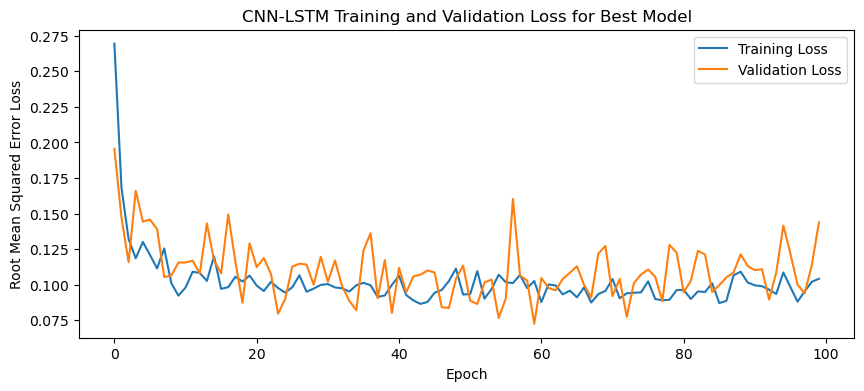

1/1 - 2s - loss: 0.1083 - 2s/epoch - 2s/step
Test Loss: 0.10831555724143982


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

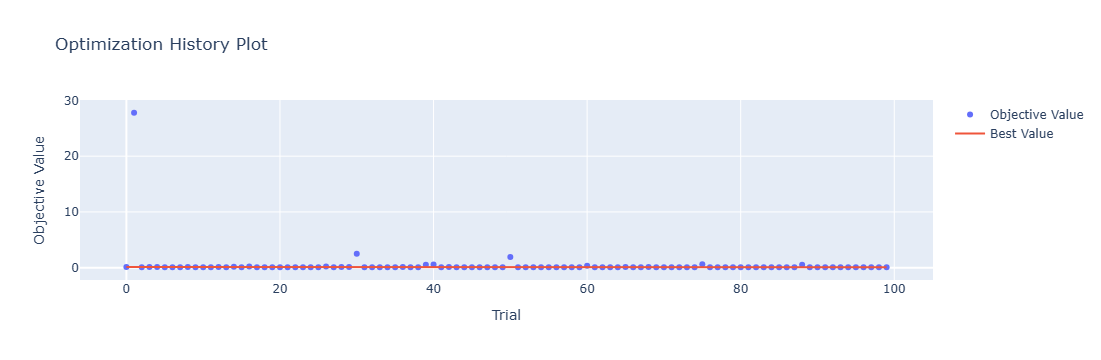

In [4]:
optuna.visualization.plot_optimization_history(study)

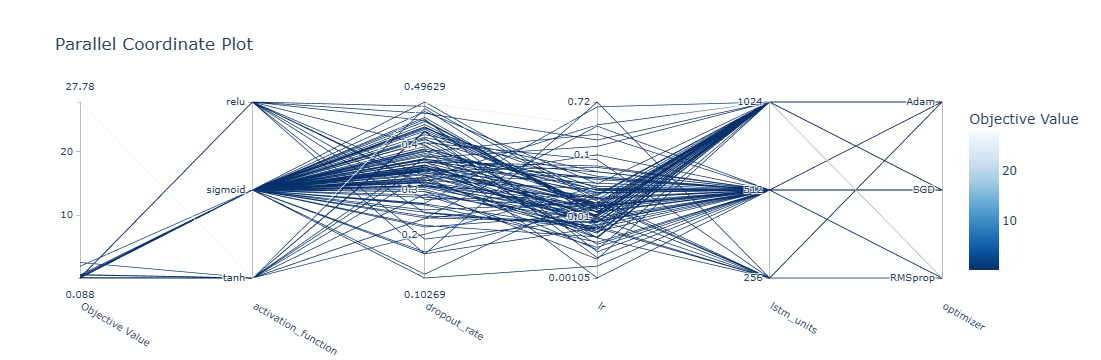

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

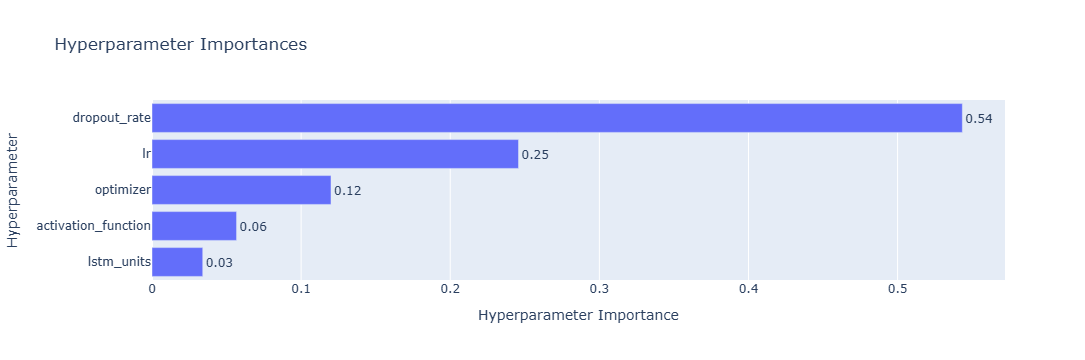

In [6]:
optuna.visualization.plot_param_importances(study)

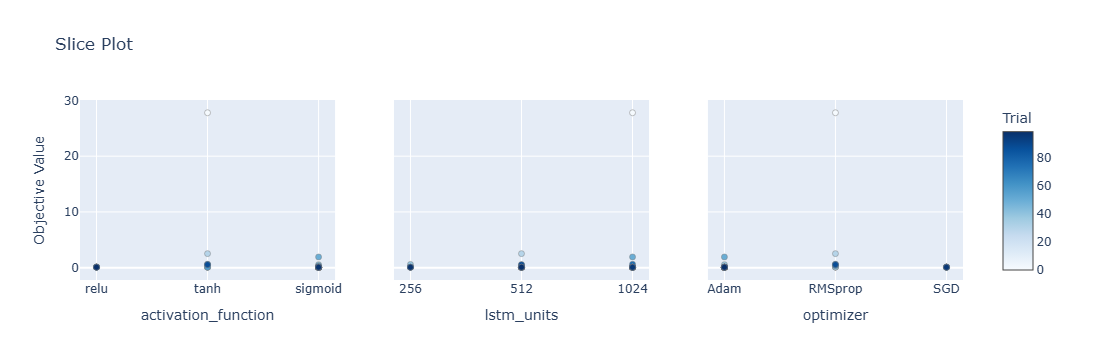

In [9]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

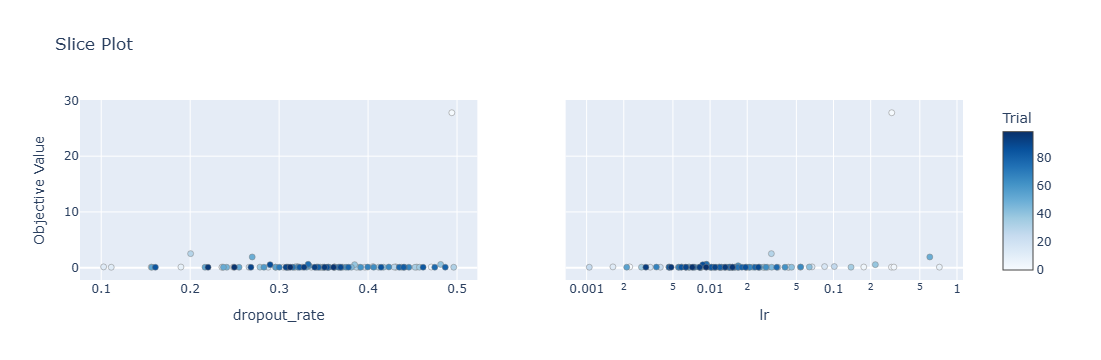

In [10]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 7s 154ms/step - loss: 0.2555 - accuracy: 0.0526 - mae: 0.2084 - rmse: 0.2555 - mape: 50.8559 - pearson: 0.0815 - val_loss: 0.1403 - val_accuracy: 0.0000e+00 - val_mae: 0.1120 - val_rmse: 0.1403 - val_mape: 27.3586 - val_pearson: 0.2004
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1362 - accuracy: 0.1579 - mae: 0.1109 - rmse: 0.1362 - mape: 27.6047 - pearson: 0.1794 - val_loss: 0.1366 - val_accuracy: 0.0000e+00 - val_mae: 0.1193 - val_rmse: 0.1366 - val_mape: 28.6907 - val_pearson: 0.0764
Epoch 3/100
19/19 [==============================] - 1s 44ms/step - loss: 0.1236 - a

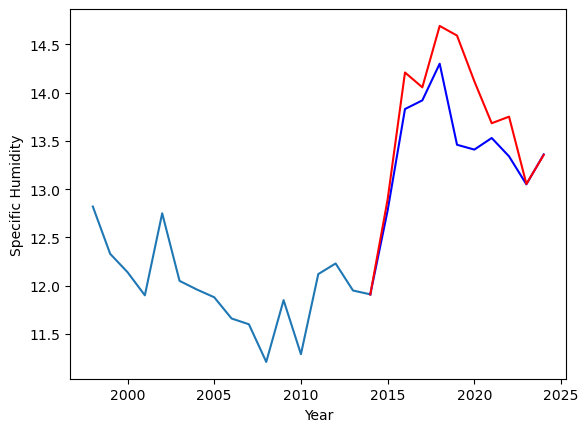

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		10.14		0.43
10.79		11.46		0.67
10.20		11.31		1.11
10.87		11.94		1.07
10.99		11.84		0.85
10.80		11.37		0.57
11.01		10.93		-0.08
10.57		11.00		0.43
10.05		10.30		0.25
10.24		10.60		0.36


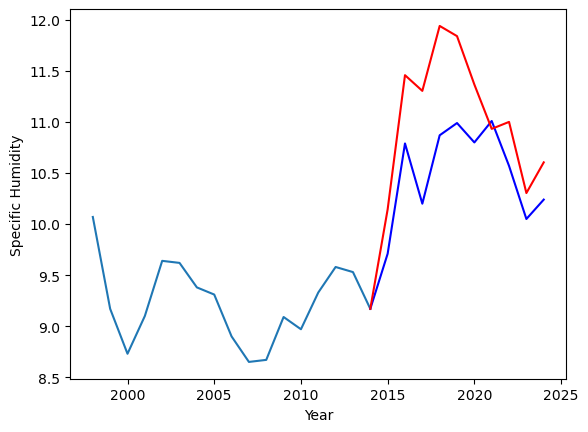

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78   12.89466
1                1    9.71   10.14466


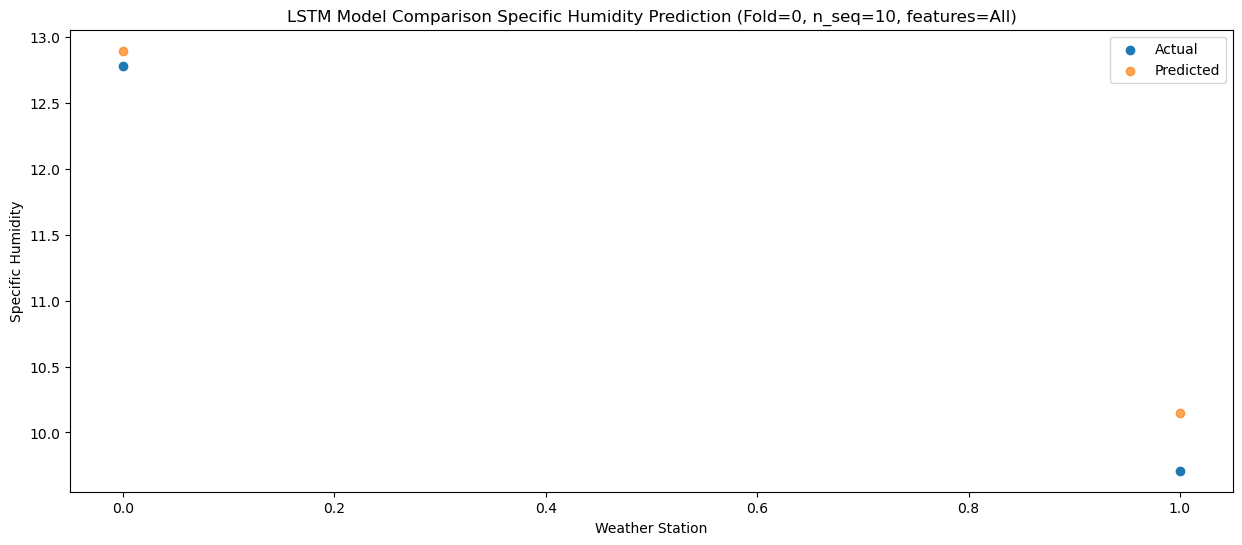

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  14.208819
1                1   10.79  11.458819


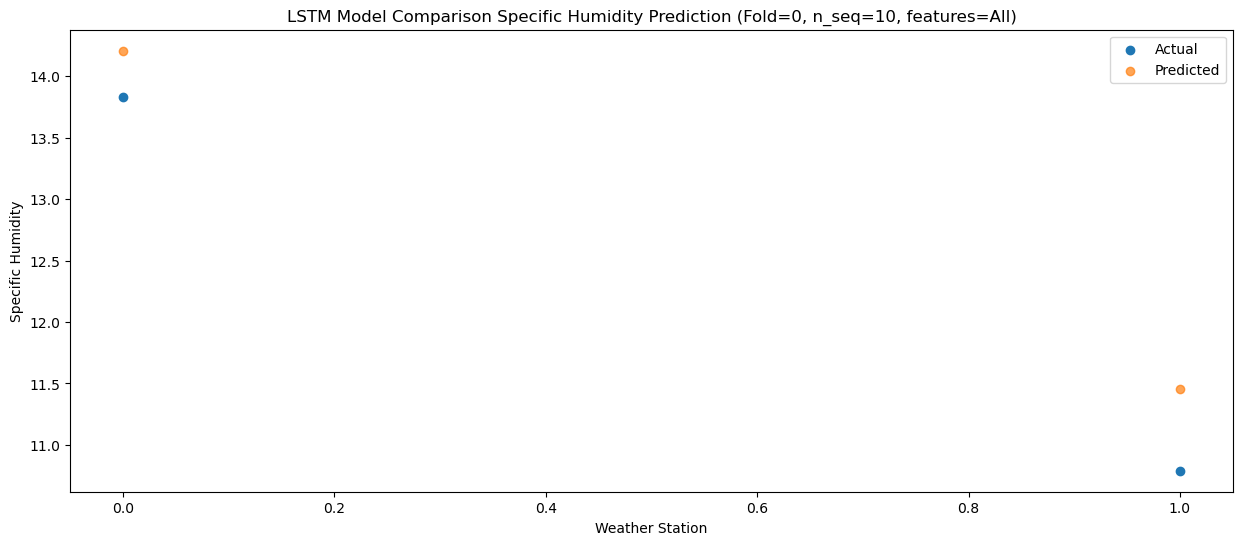

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  14.055059
1                1   10.20  11.305059


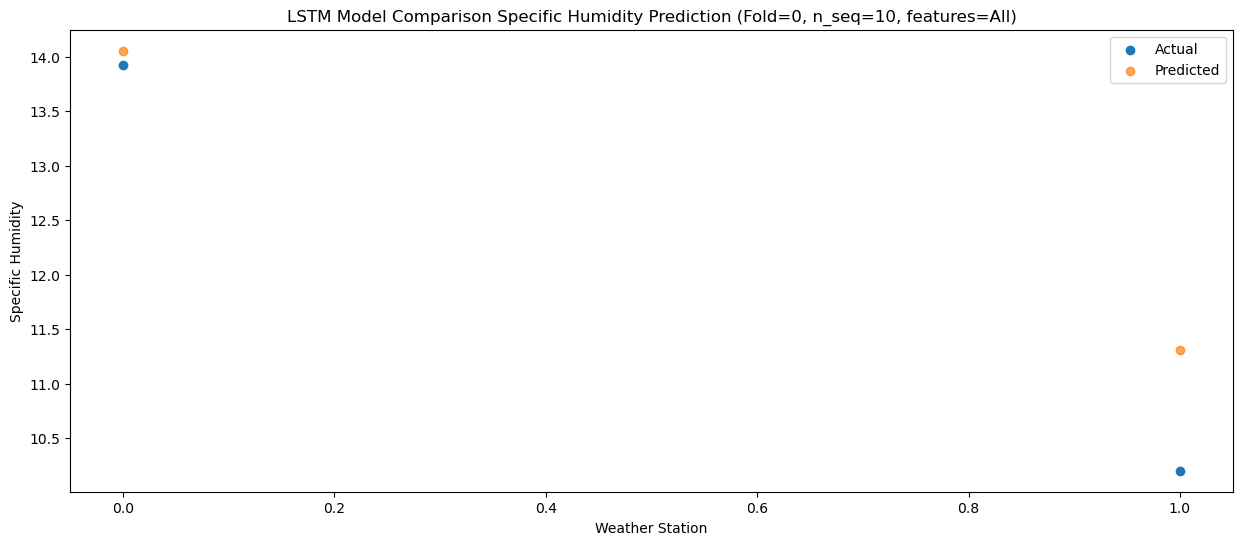

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  14.691313
1                1   10.87  11.941313


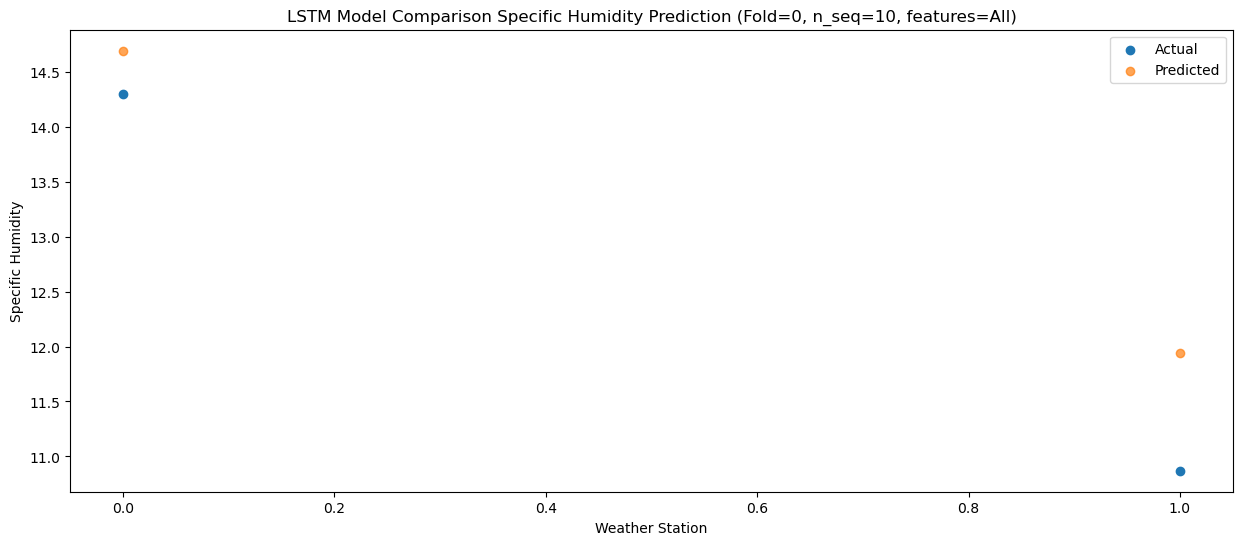

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  14.591381
1                1   10.99  11.841382


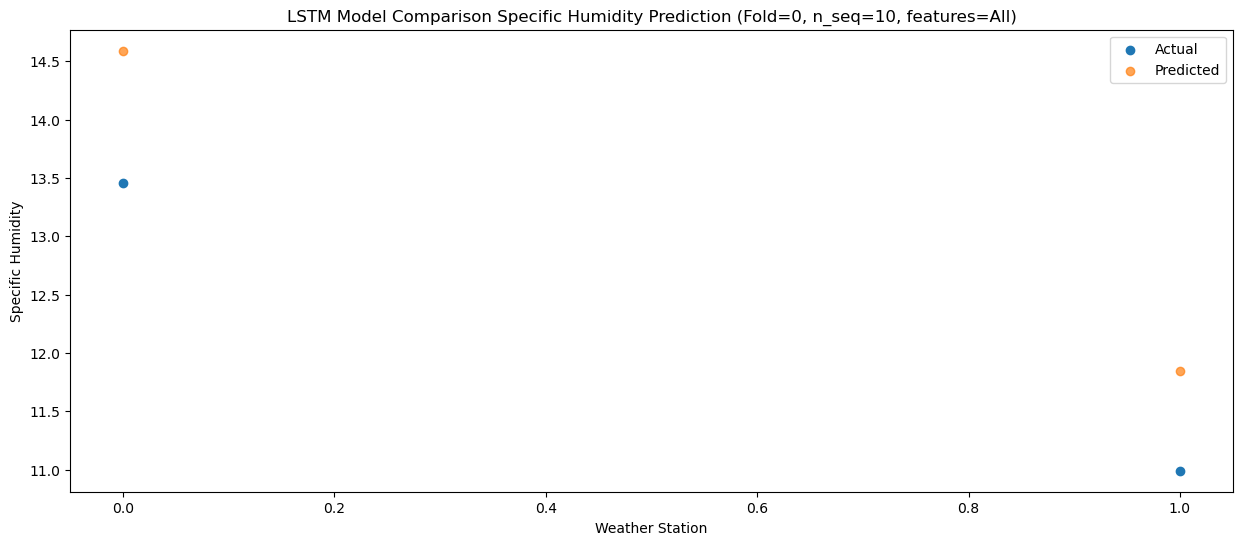

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  14.117239
1                1   10.80  11.367241


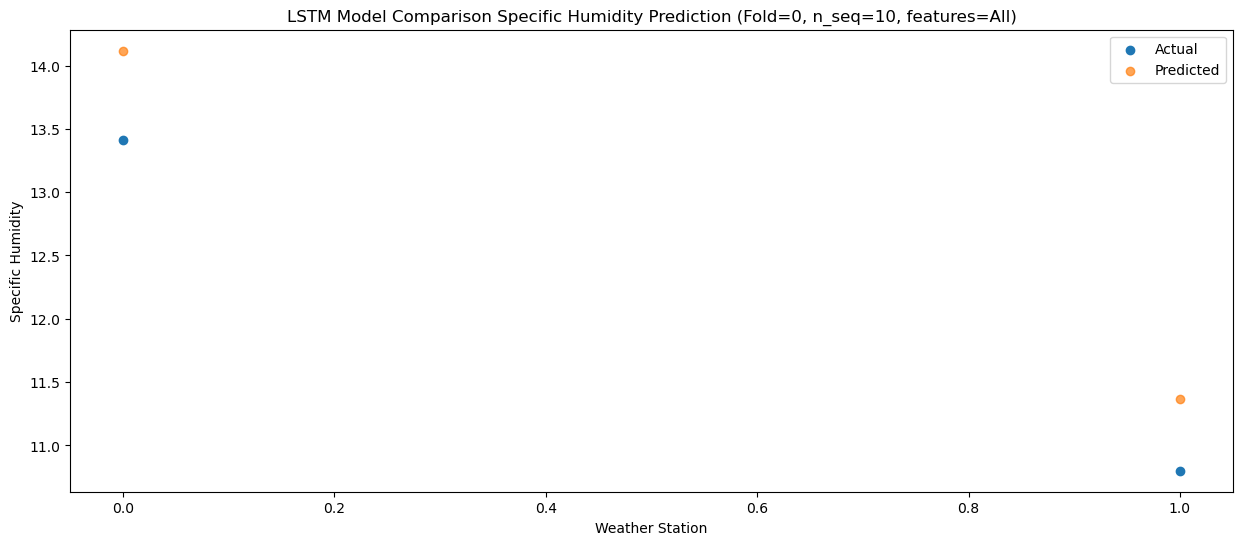

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  13.683058
1                1   11.01  10.933060


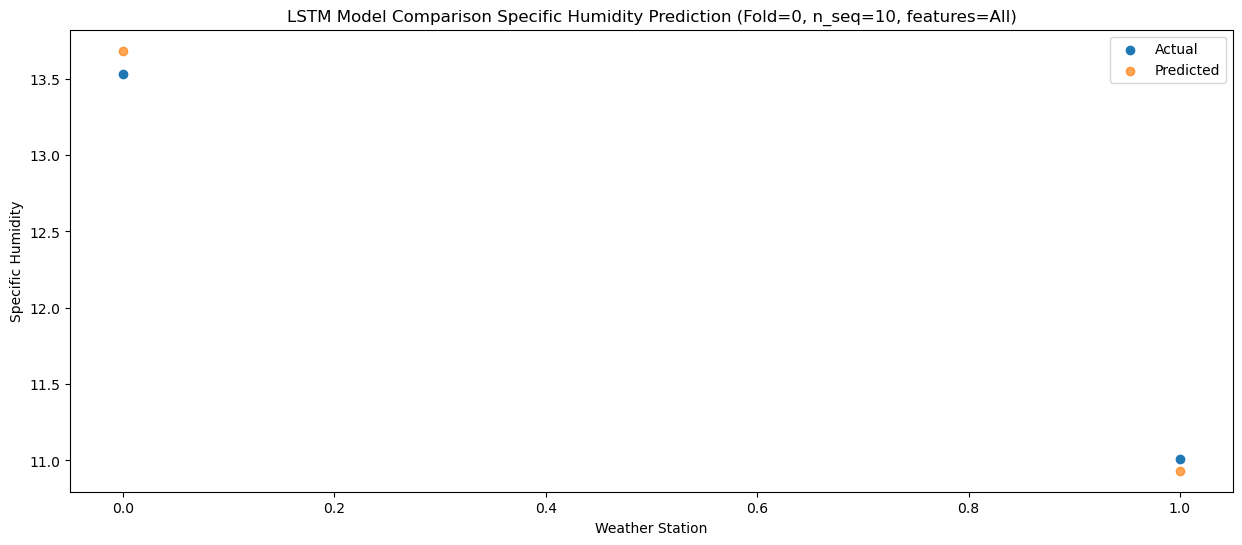

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  13.751108
1                1   10.57  11.001109


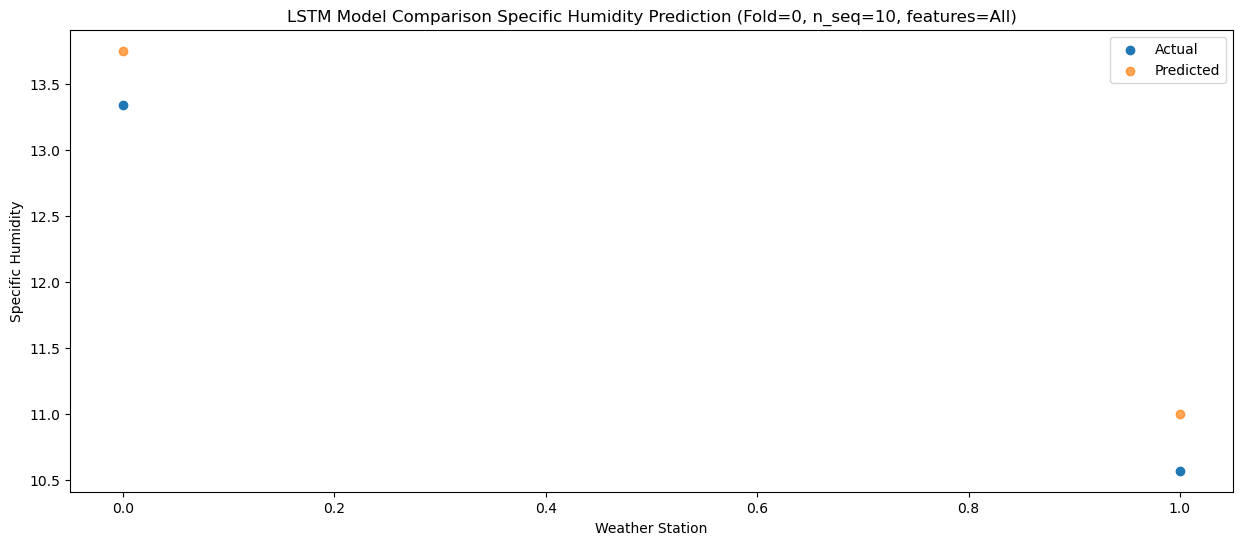

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  13.054152
1                1   10.05  10.304153


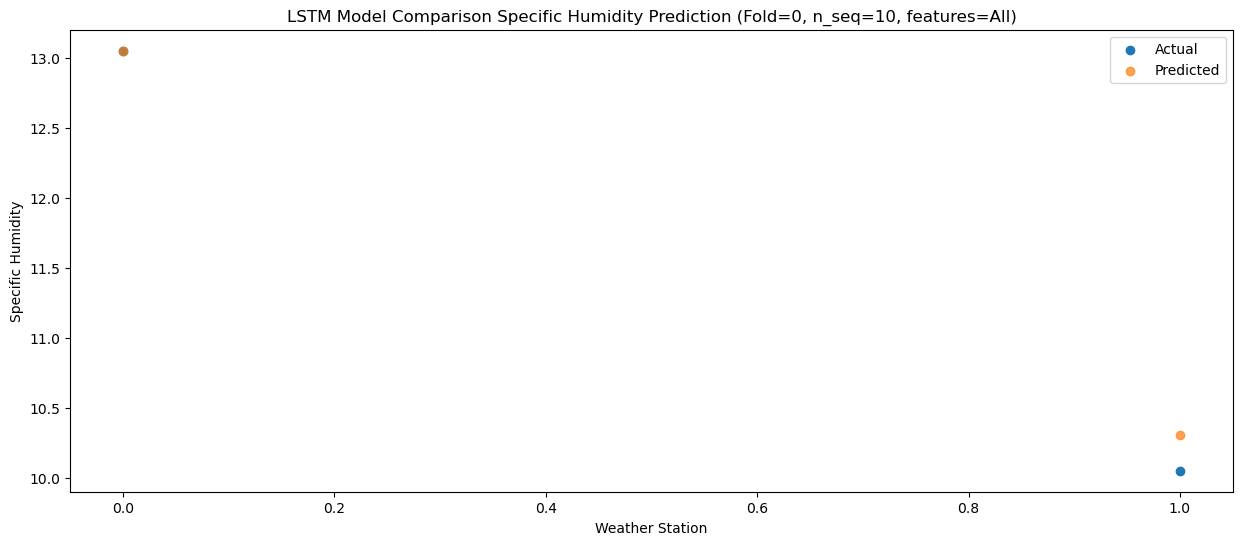

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  13.354748
1                1   10.24  10.604750


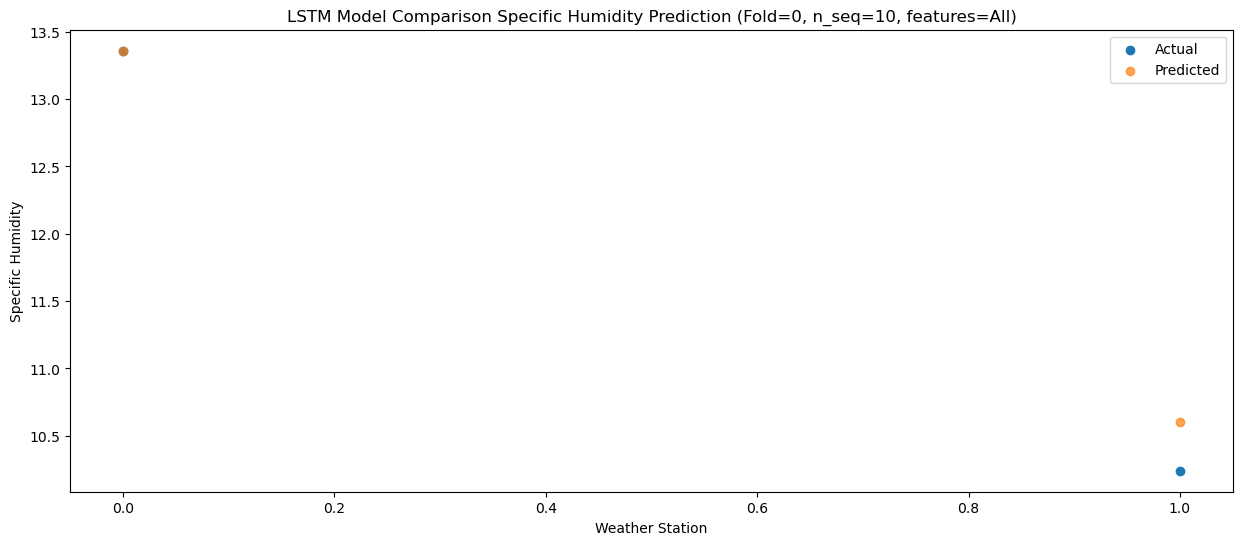

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.89466029 10.14466016]
 [14.20881873 11.45881884]
 [14.05505854 11.30505878]
 [14.69131261 11.94131315]
 [14.59138141 11.84138235]
 [14.11723948 11.36724069]
 [13.68305809 10.93305957]
 [13.75110792 11.00110939]
 [13.0541517  10.30415276]
 [13.35474841 10.60474974]]
Year at t+1:
t+1 SKRMSE: 0.317865
t+1 KRMSE: 0.317865
t+1 MAE: 0.274660
t+1 SKMAPE: 0.026868
t+1 R2_SCORE: 0.957119
t+1 KMAPE: 0.026868
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.543517
t+2 KRMSE: 0.543517
t+2 MAE: 0.523819
t+2 SKMAPE: 0.044688
t+2 R2_SCORE: 0.872139
t+2 KMAPE: 0.044688
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.787209
t+3 KRMSE: 0.787209
t+3 MAE: 0.620059
t+3 SKMAPE: 0.059021
t+3 R2_SCORE: 0.820876
t+3 KMAPE: 0.059021
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

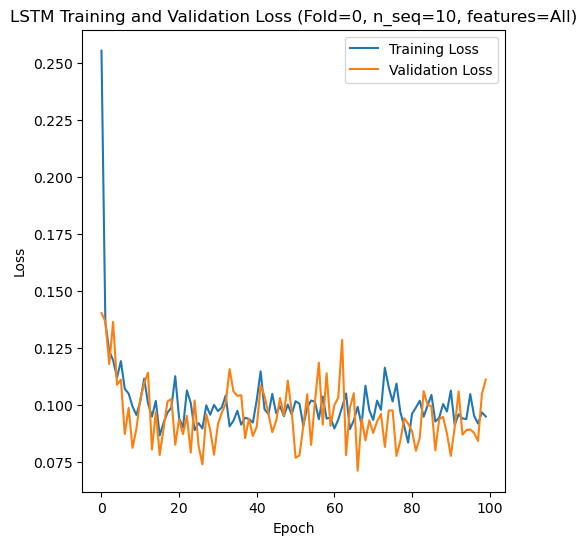

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 6s 114ms/step - loss: 0.2466 - accuracy: 0.2632 - mae: 0.2036 - rmse: 0.2466 - mape: 47.5407 - pearson: 0.1276 - val_loss: 0.1725 - val_accuracy: 0.0000e+00 - val_mae: 0.1417 - val_rmse: 0.1725 - val_mape: 36.6728 - val_pearson: 0.2803
Epoch 2/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1390 - accuracy: 0.0000e+00 - mae: 0.1200 - rmse: 0.1390 - mape: 28.7331 - pearson: 0.1479 - val_loss: 0.1247 - val_accuracy: 0.0000e+00 - val_mae: 0.1075 - val_rmse: 0.1247 - val_mape: 26.7931 - val_pearson: 0.0169
Epoch 3/100
19/19 [==============================] - 1s 46ms/step - loss: 0.1189

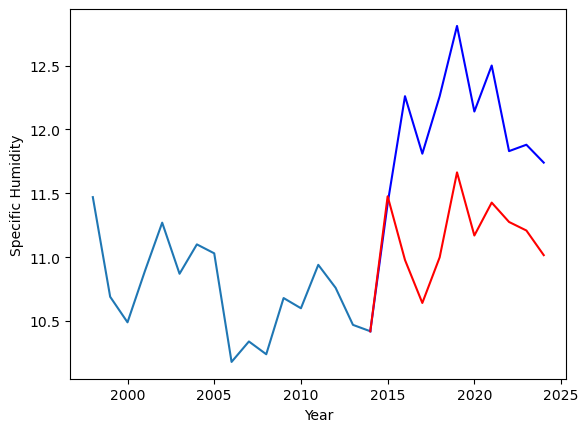

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.64		-0.31
9.08		7.14		-1.94
9.06		6.80		-2.26
8.69		7.16		-1.53
8.53		7.82		-0.71
8.56		7.33		-1.23
7.82		7.59		-0.23
8.26		7.44		-0.82
7.69		7.37		-0.32
7.84		7.18		-0.66


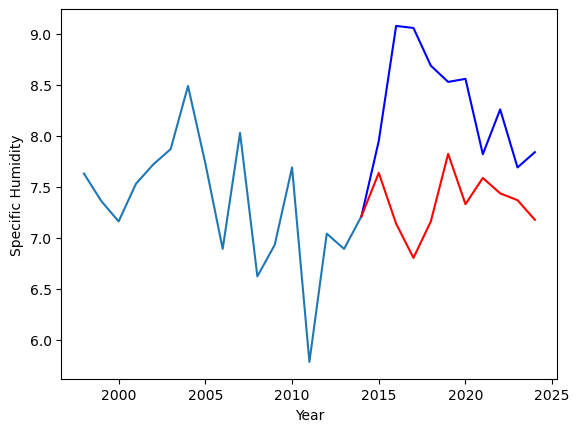

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.476494
1                1    7.95   7.636494


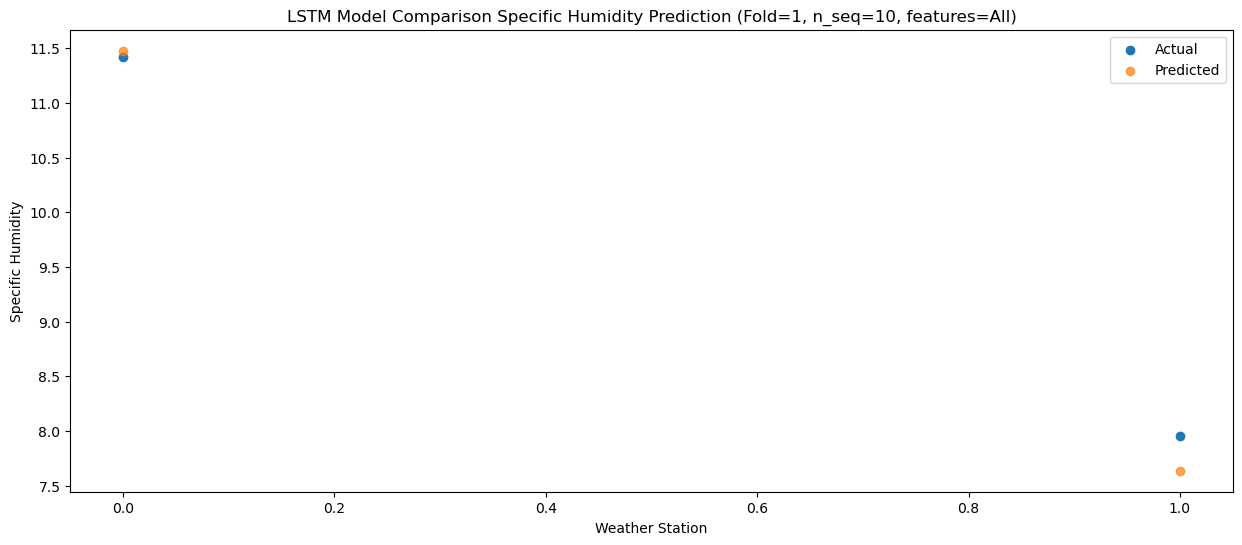

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  10.977919
1                1    9.08   7.137919


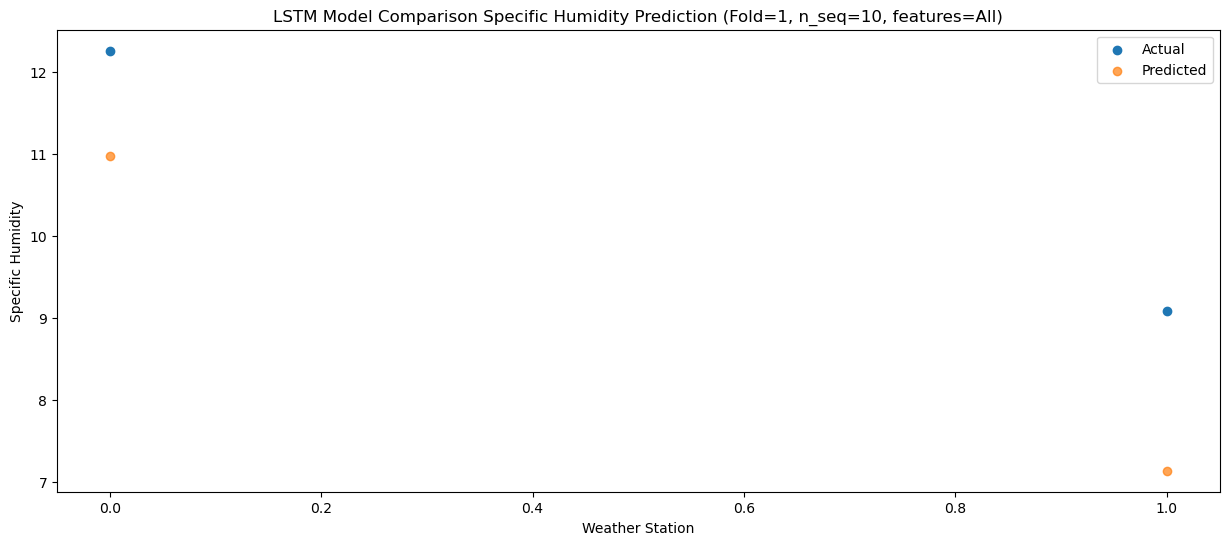

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  10.641502
1                1    9.06   6.801502


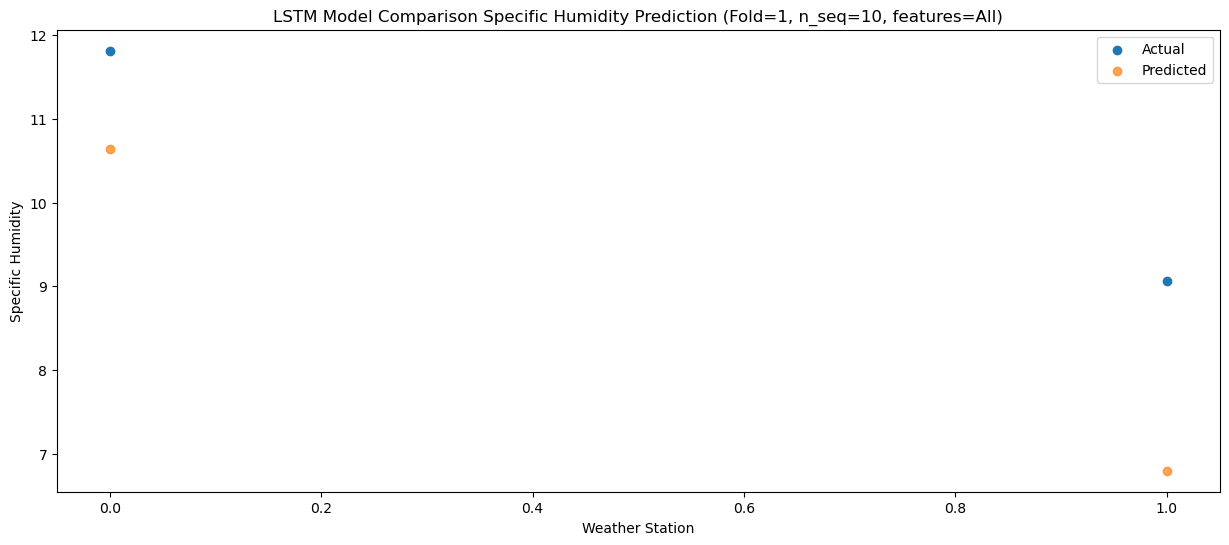

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  10.998923
1                1    8.69   7.158923


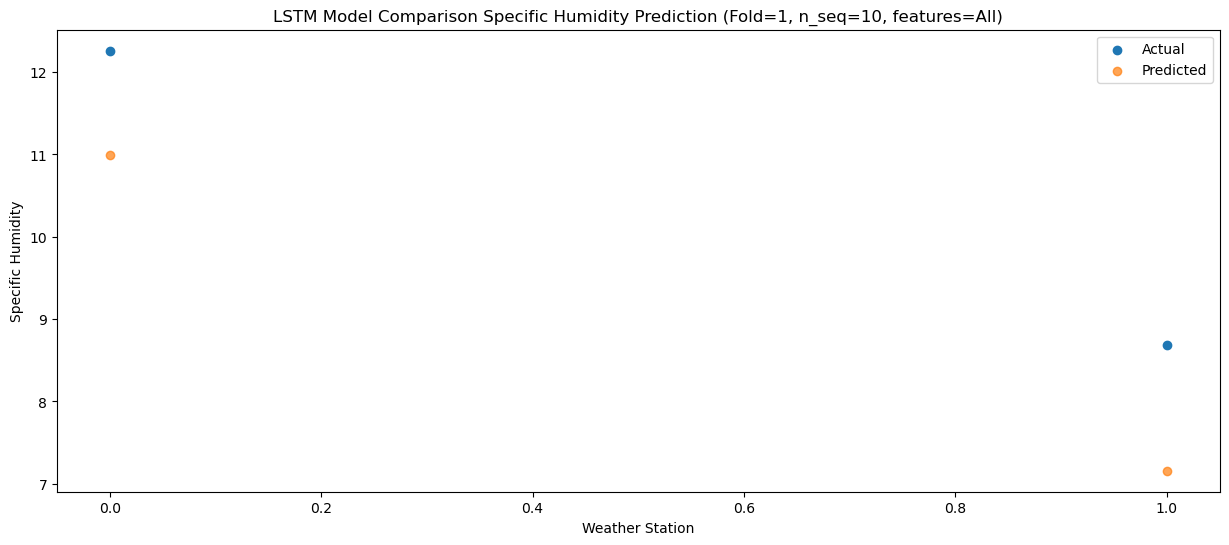

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  11.663575
1                1    8.53   7.823576


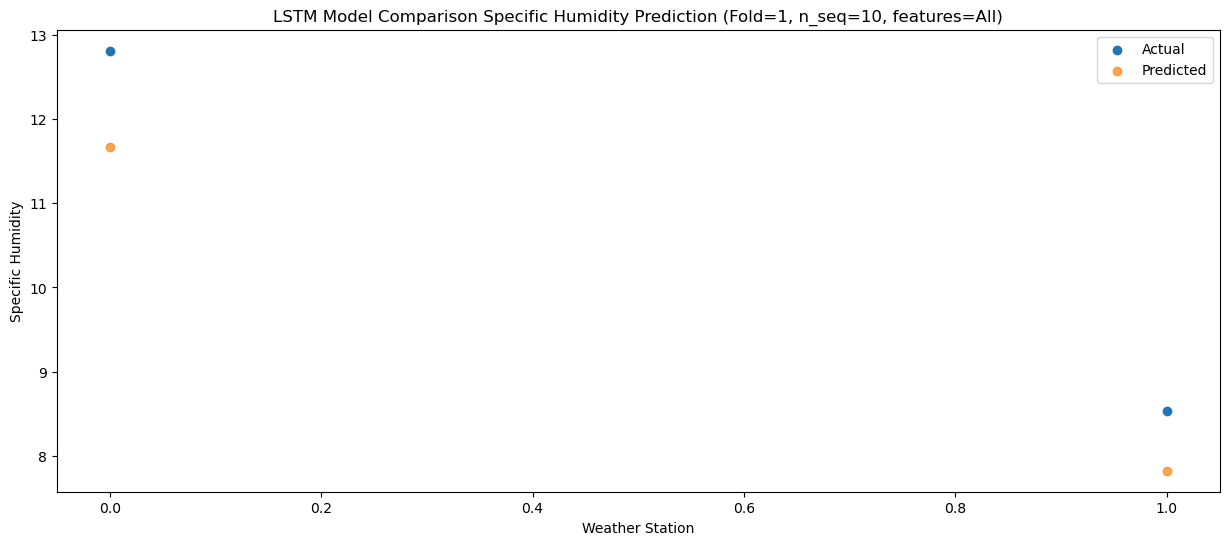

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.169447
1                1    8.56   7.329447


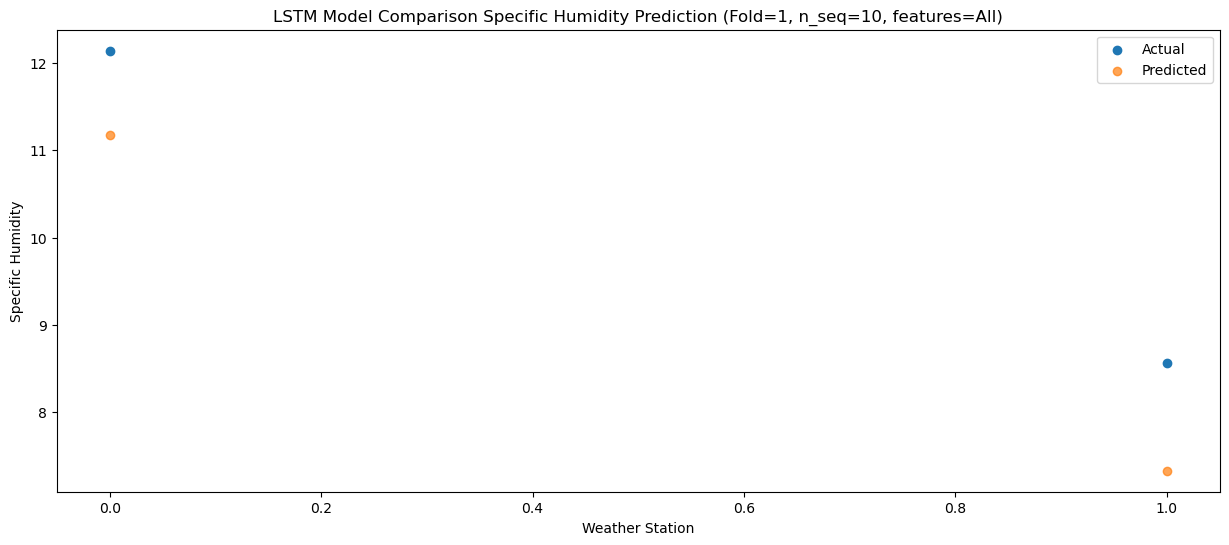

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  11.426997
1                1    7.82   7.586998


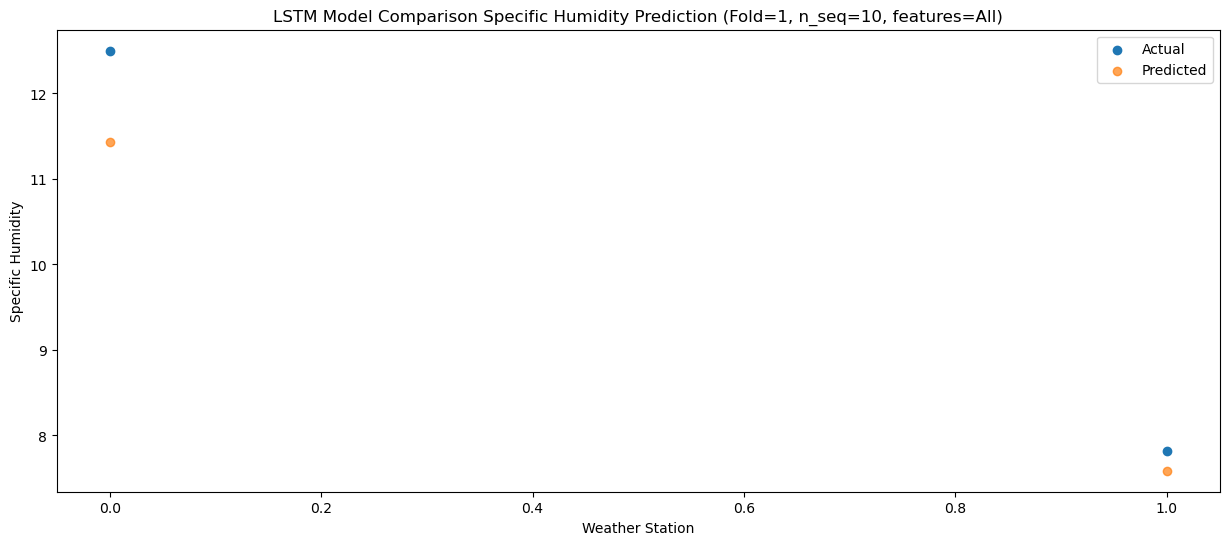

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  11.275514
1                1    8.26   7.435515


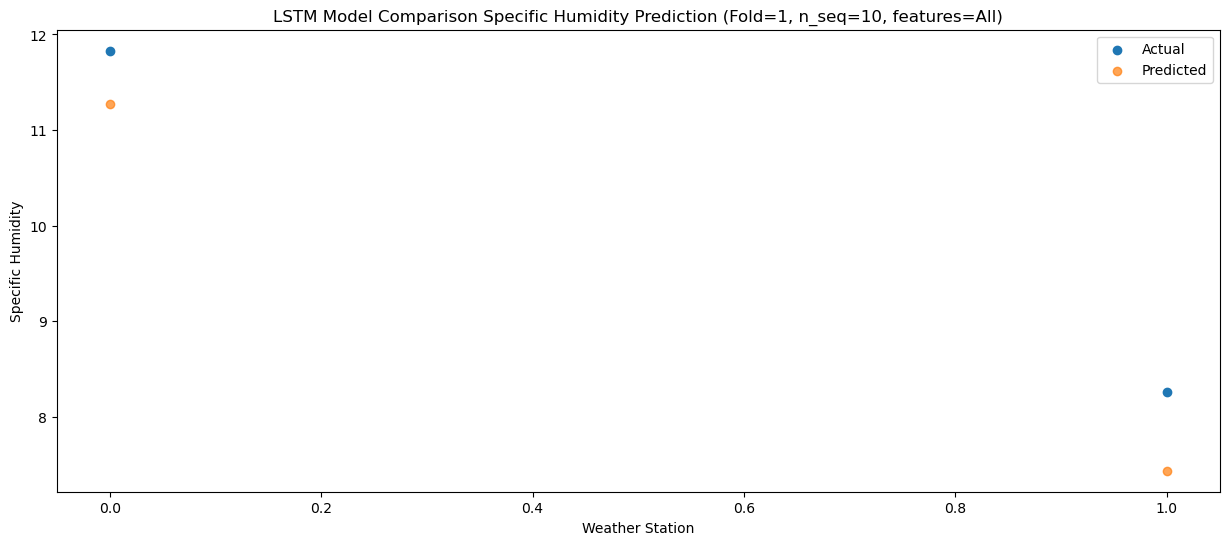

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.208595
1                1    7.69   7.368595


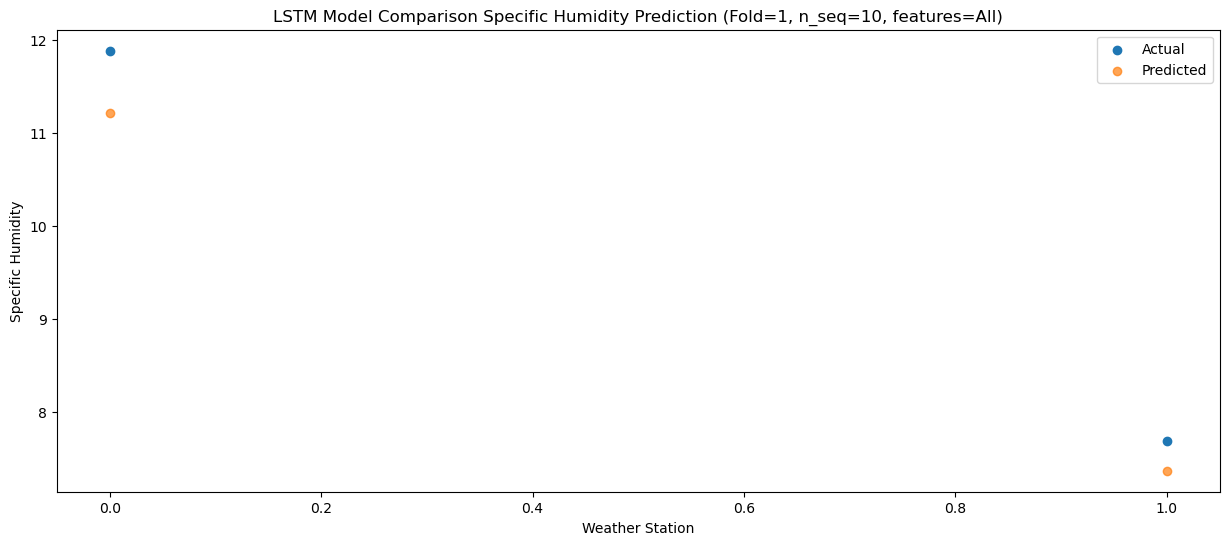

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.015762
1                1    7.84   7.175763


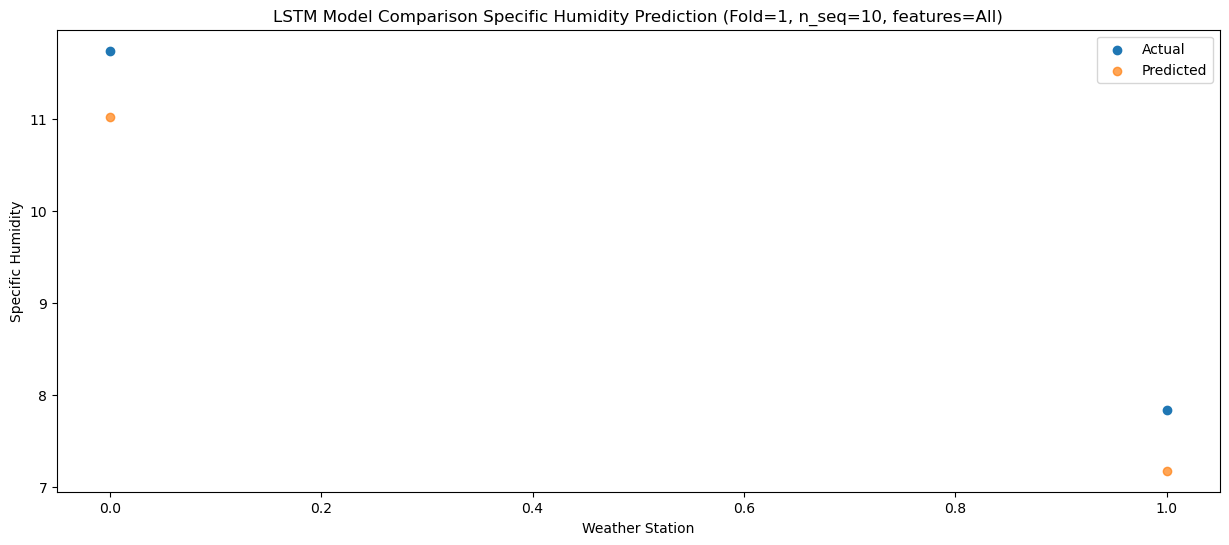

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.47649397  7.63649397]
 [10.97791921  7.13791921]
 [10.64150201  6.80150201]
 [10.99892276  7.15892276]
 [11.66357546  7.8235757 ]
 [11.16944685  7.32944708]
 [11.42699721  7.58699759]
 [11.2755144   7.43551452]
 [11.20859463  7.36859502]
 [11.01576241  7.17576349]]
Year at t+1:
t+1 SKRMSE: 0.225253
t+1 KRMSE: 0.225253
t+1 MAE: 0.185000
t+1 SKMAPE: 0.022191
t+1 R2_SCORE: 0.983145
t+1 KMAPE: 0.022191
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 1.645510
t+2 KRMSE: 1.645510
t+2 MAE: 1.612081
t+2 SKMAPE: 0.159230
t+2 R2_SCORE: -0.071043
t+2 KMAPE: 0.159230
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 1.798082
t+3 KRMSE: 1.798082
t+3 MAE: 1.713498
t+3 SKMAPE: 0.174112
t+3 R2_SCORE: -0.710070
t+3 KMAPE: 0.174112
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at

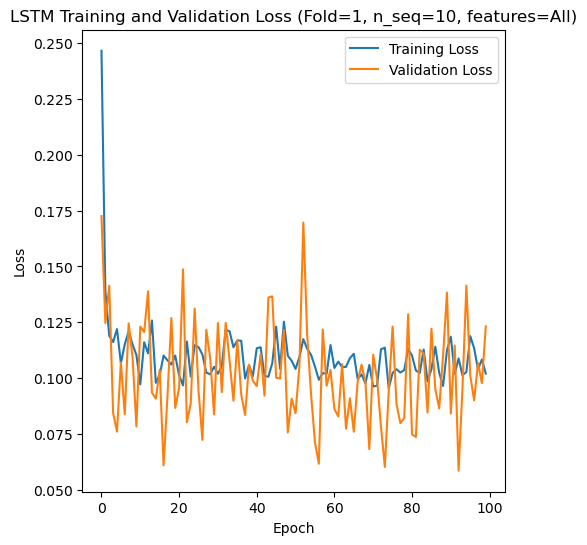

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 6s 110ms/step - loss: 0.3307 - accuracy: 0.1579 - mae: 0.2684 - rmse: 0.3307 - mape: 61.7706 - pearson: 0.1148 - val_loss: 0.1484 - val_accuracy: 0.0000e+00 - val_mae: 0.1140 - val_rmse: 0.1484 - val_mape: 28.9205 - val_pearson: 0.0115
Epoch 2/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1445 - accuracy: 0.1053 - mae: 0.1196 - rmse: 0.1445 - mape: 28.6714 - pearson: 0.0873 - val_loss: 0.1170 - val_accuracy: 0.3333 - val_mae: 0.0976 - val_rmse: 0.1170 - val_mape: 22.9462 - val_pearson: 0.0597
Epoch 3/100
19/19 [==============================] - 1s 44ms/step - loss: 0.1136 - accur

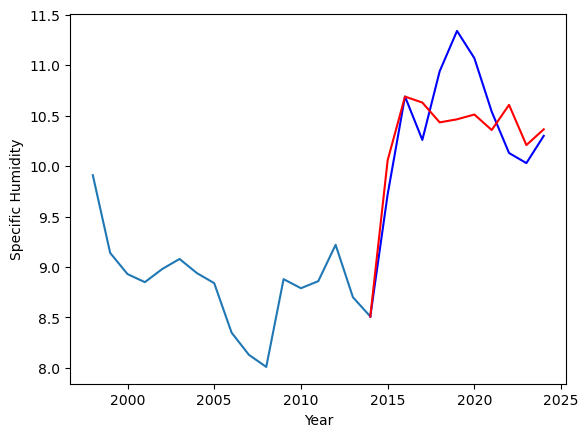

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.64		0.96
8.43		9.27		0.84
8.98		9.21		0.23
8.93		9.01		0.08
9.03		9.04		0.01
8.38		9.09		0.71
8.20		8.94		0.74
8.27		9.19		0.92
8.54		8.79		0.25
8.55		8.94		0.39


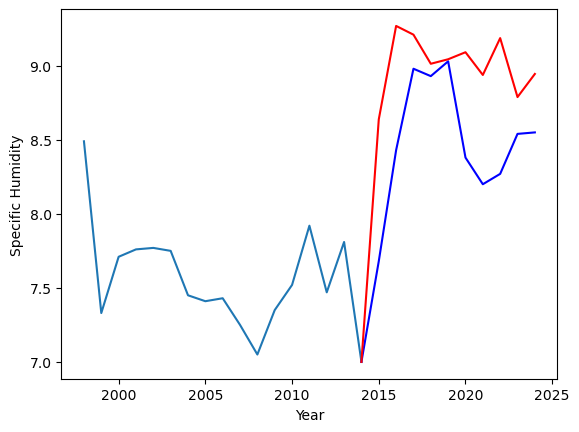

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72  10.057954
1                1    7.68   8.637955


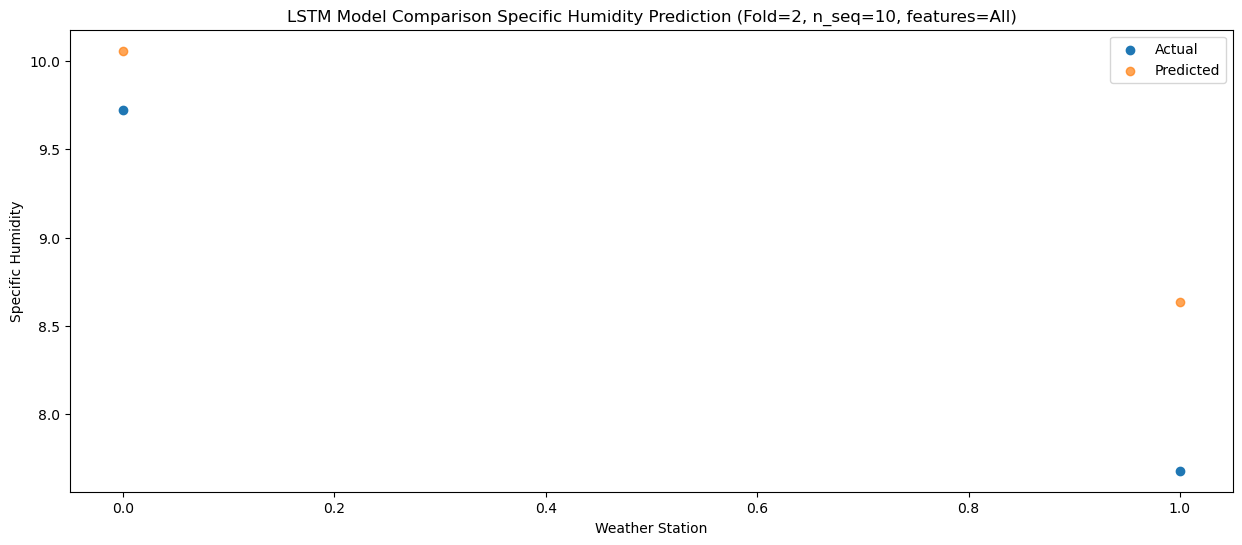

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.689124
1                1    8.43   9.269124


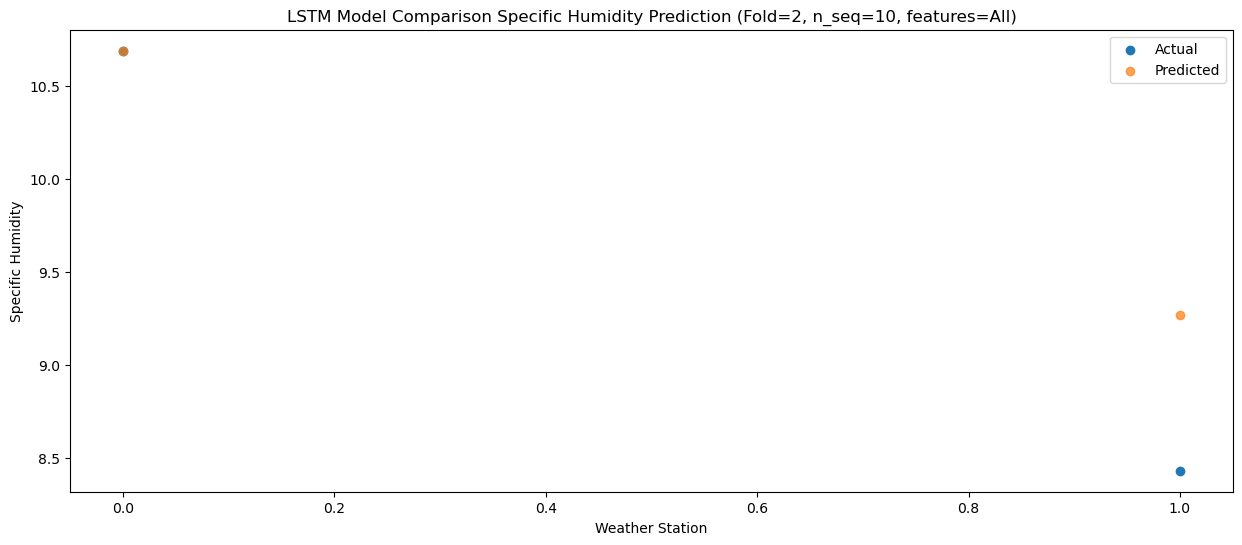

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26   10.63009
1                1    8.98    9.21009


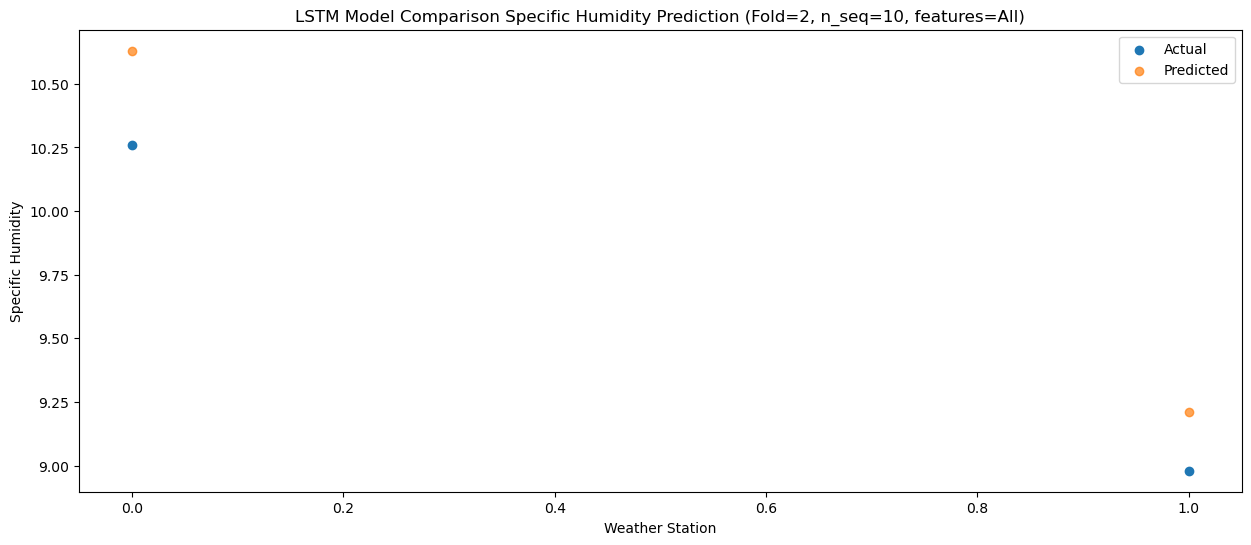

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.433556
1                1    8.93   9.013556


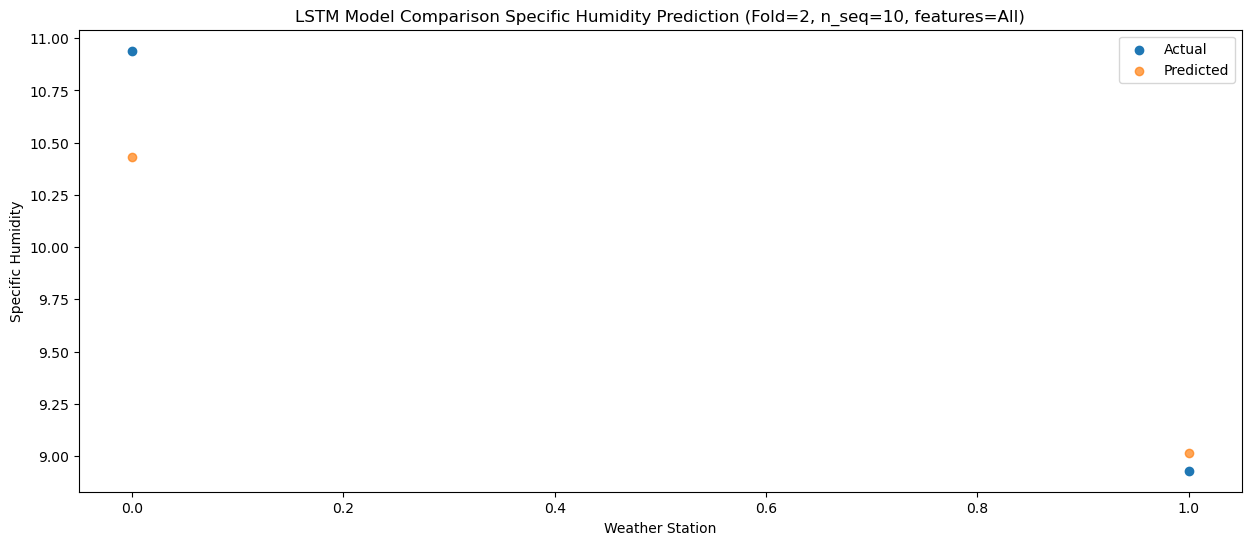

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.463987
1                1    9.03   9.043987


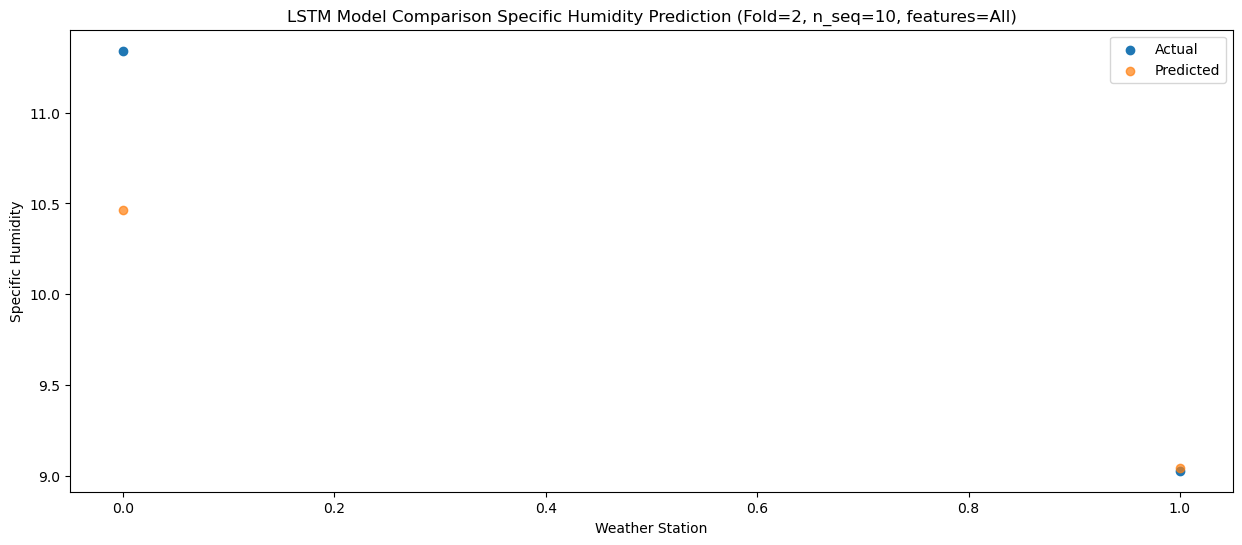

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.511478
1                1    8.38   9.091478


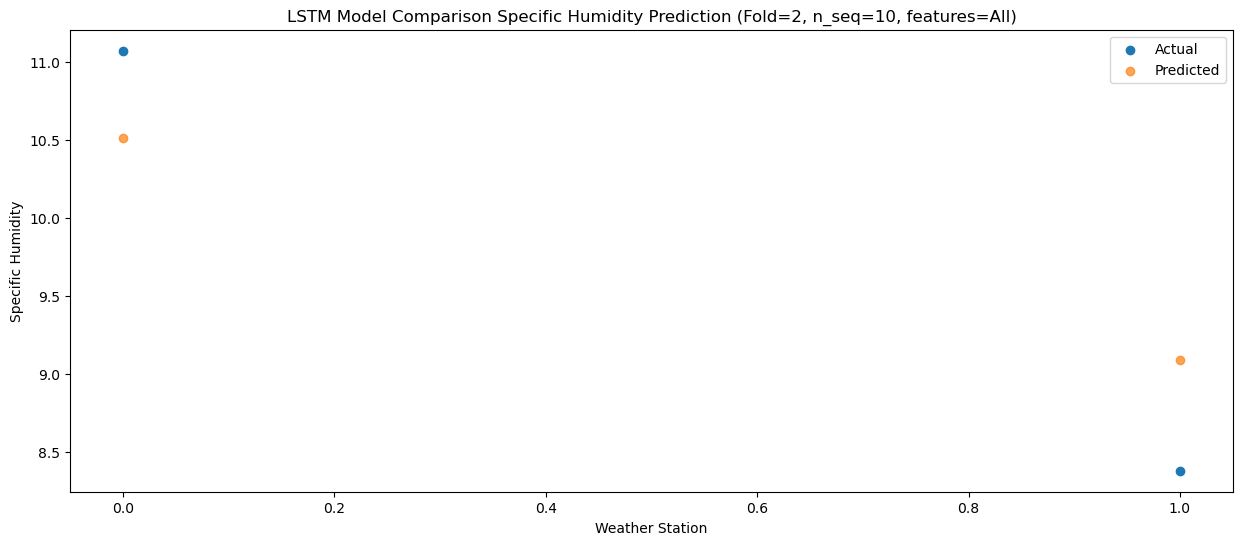

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.357915
1                1    8.20   8.937915


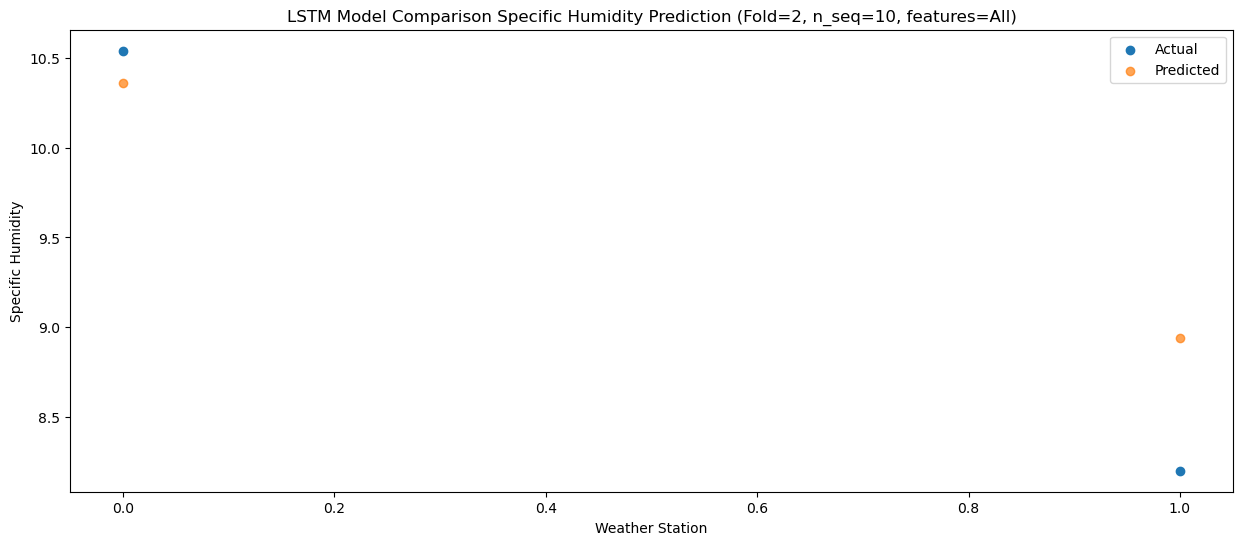

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.606897
1                1    8.27   9.186897


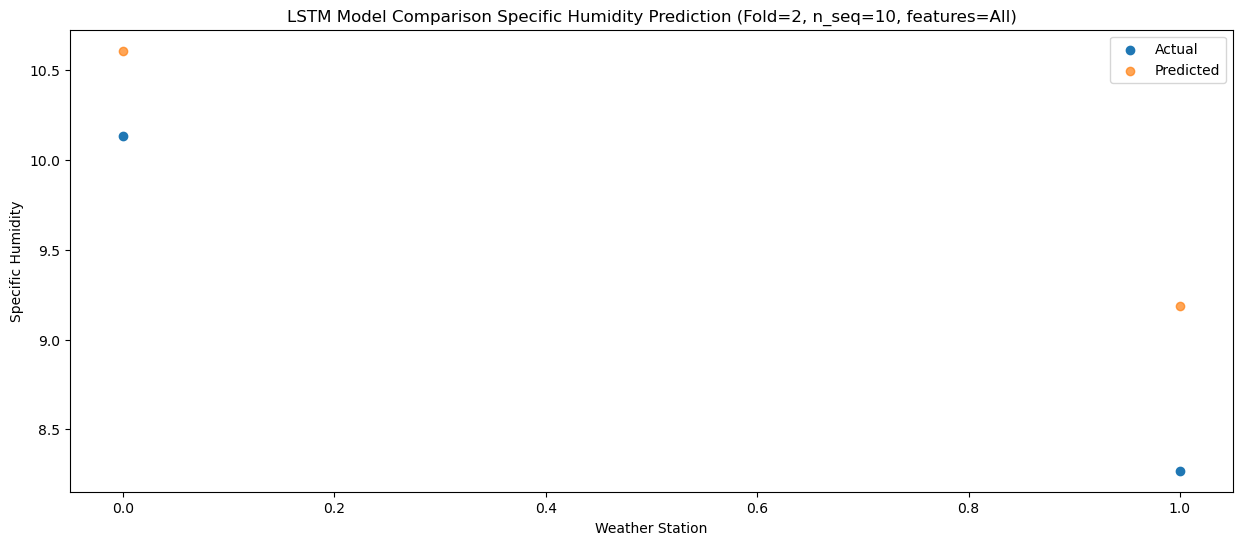

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03  10.208559
1                1    8.54   8.788559


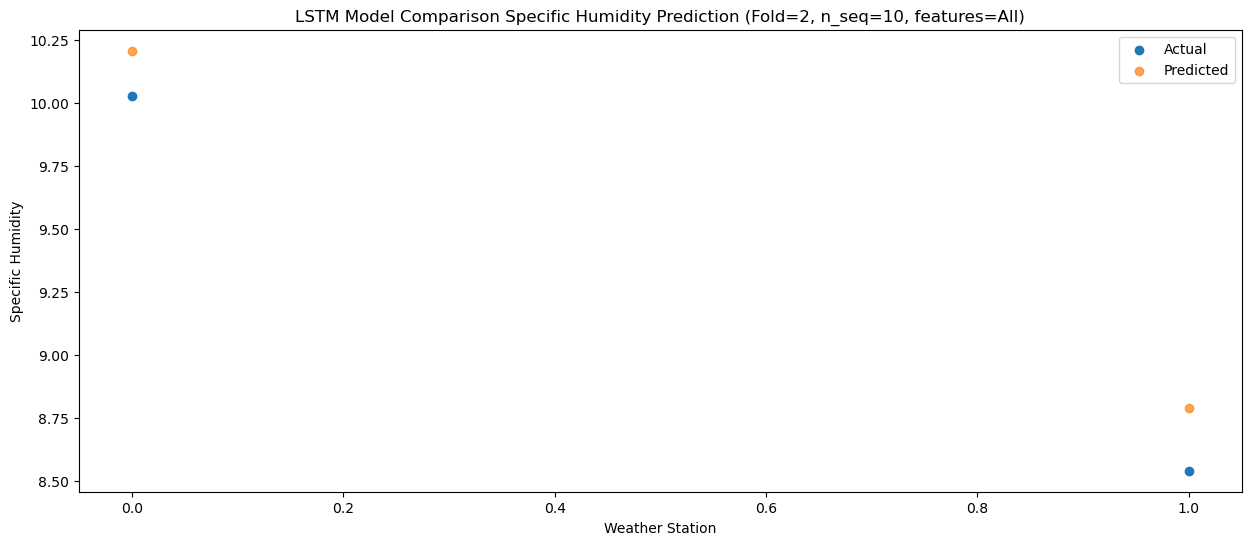

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.364763
1                1    8.55   8.944763


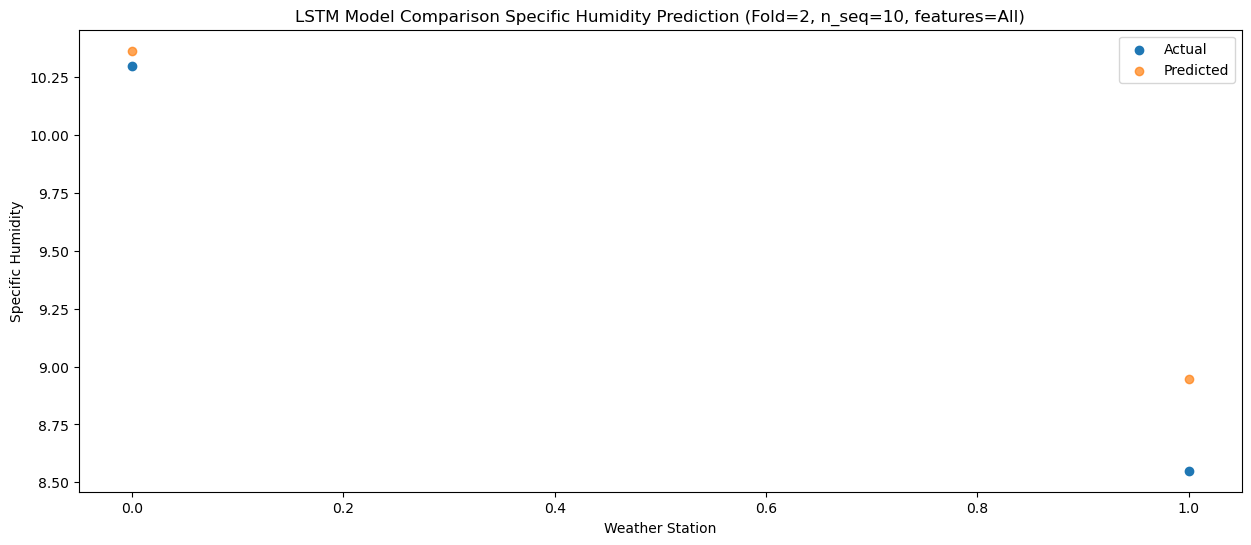

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[10.0579544   8.63795455]
 [10.68912354  9.26912369]
 [10.63009001  9.21009015]
 [10.43355604  9.01355619]
 [10.46398668  9.04398683]
 [10.51147783  9.09147798]
 [10.35791509  8.93791483]
 [10.60689704  9.18689679]
 [10.20855941  8.78855915]
 [10.36476283  8.94476284]]
Year at t+1:
t+1 SKRMSE: 0.718293
t+1 KRMSE: 0.718293
t+1 MAE: 0.647954
t+1 SKMAPE: 0.079751
t+1 R2_SCORE: 0.504090
t+1 KMAPE: 0.079751
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.593350
t+2 KRMSE: 0.593350
t+2 MAE: 0.420000
t+2 SKMAPE: 0.049811
t+2 R2_SCORE: 0.724282
t+2 KMAPE: 0.049811
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.308146
t+3 KRMSE: 0.308146
t+3 MAE: 0.300090
t+3 SKMAPE: 0.030847
t+3 R2_SCORE: 0.768179
t+3 KMAPE: 0.030847
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

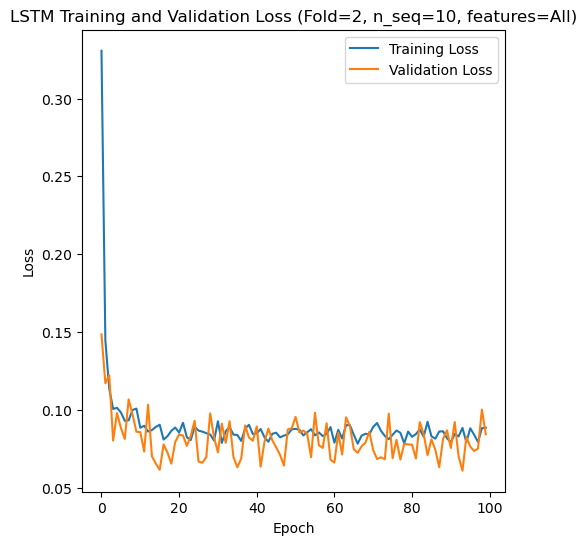

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 7s 113ms/step - loss: 0.2908 - accuracy: 0.1000 - mae: 0.2445 - rmse: 0.2908 - mape: 41.7476 - pearson: 0.1397 - val_loss: 0.1932 - val_accuracy: 0.0000e+00 - val_mae: 0.1597 - val_rmse: 0.1932 - val_mape: 27.5472 - val_pearson: 0.2088
Epoch 2/100
20/20 [==============================] - 1s 42ms/step - loss: 0.1947 - accuracy: 0.3500 - mae: 0.1620 - rmse: 0.1947 - mape: 27.8142 - pearson: 0.1961 - val_loss: 0.1562 - val_accuracy: 0.0000e+00 - val_mae: 0.1235 - val_rmse: 0.1562 - val_mape: 19.7265 - val_pearson: 0.0578
Epoch 3/100
20/20 [==============================] - 1s 42ms/step - loss: 0.1739 - accuracy: 0.3000 - mae: 0.1381 - rmse: 0.1739 - mape: 23.64

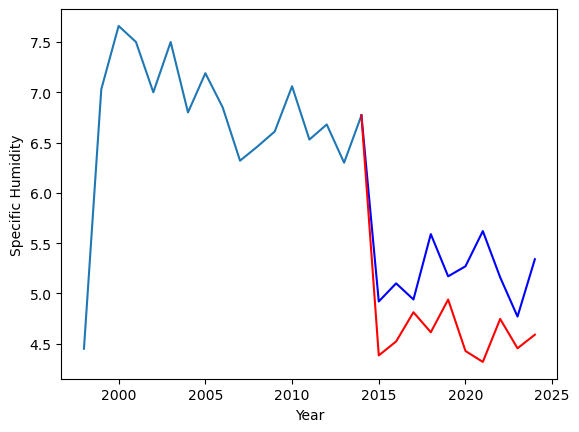

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		8.26		0.31
8.59		8.40		-0.19
8.69		8.69		0.00
8.51		8.49		-0.02
8.87		8.82		-0.05
8.75		8.31		-0.44
8.66		8.20		-0.46
8.63		8.63		-0.00
8.16		8.33		0.17
8.18		8.47		0.29


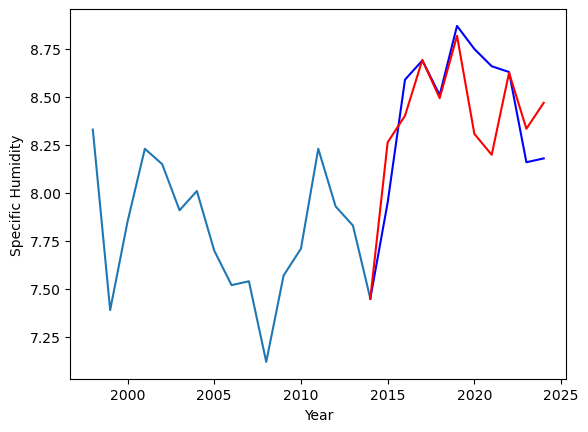

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.383524
1                1    7.95   8.263524


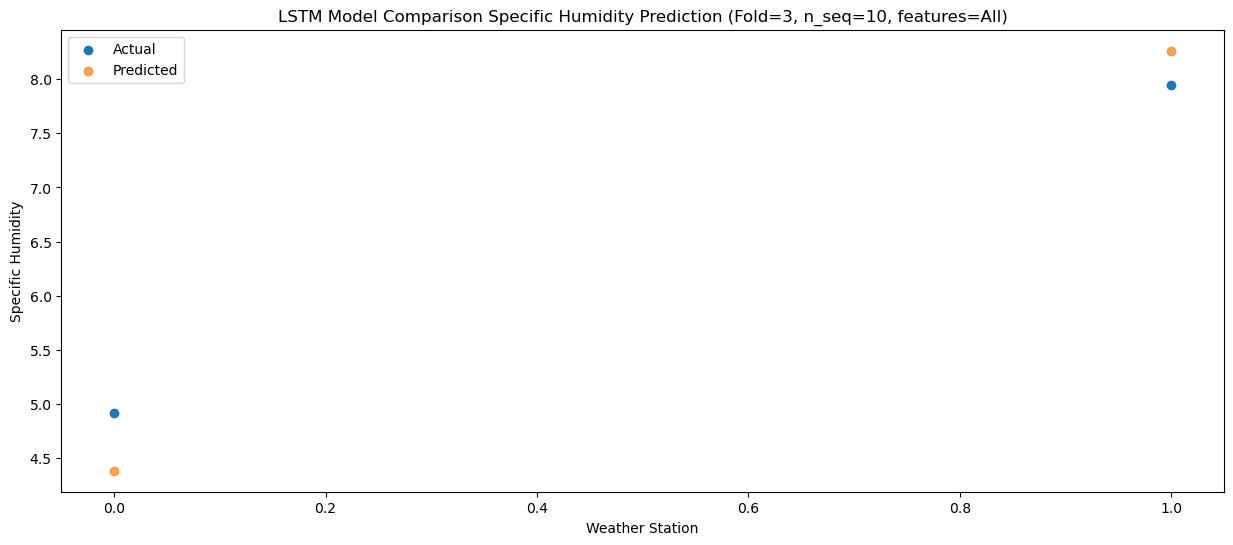

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10    4.52231
1                1    8.59    8.40231


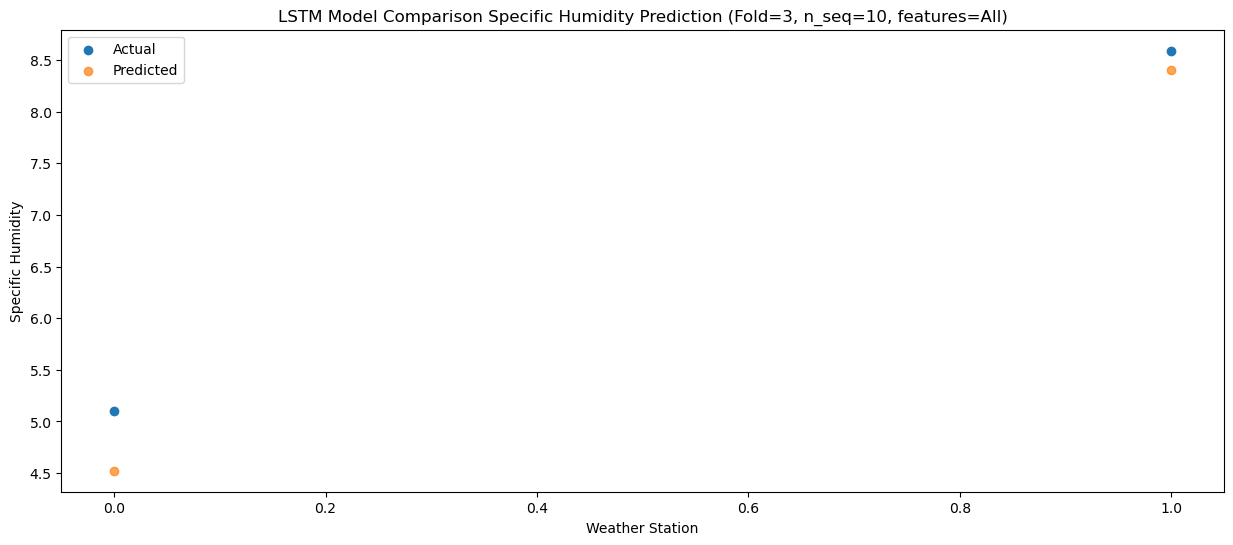

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.812973
1                1    8.69   8.692973


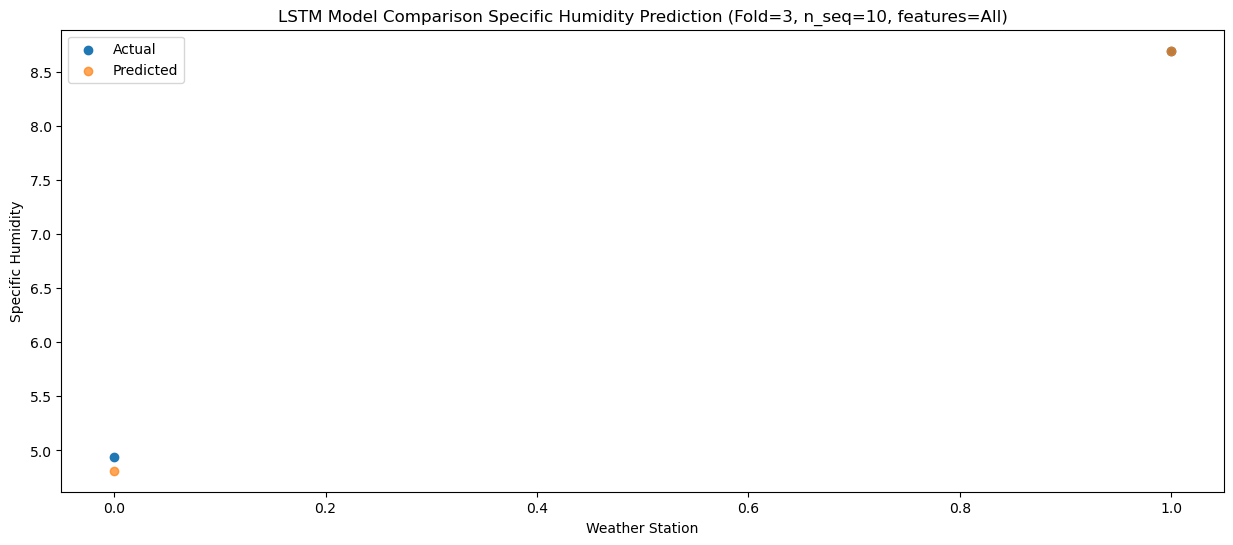

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.613768
1                1    8.51   8.493769


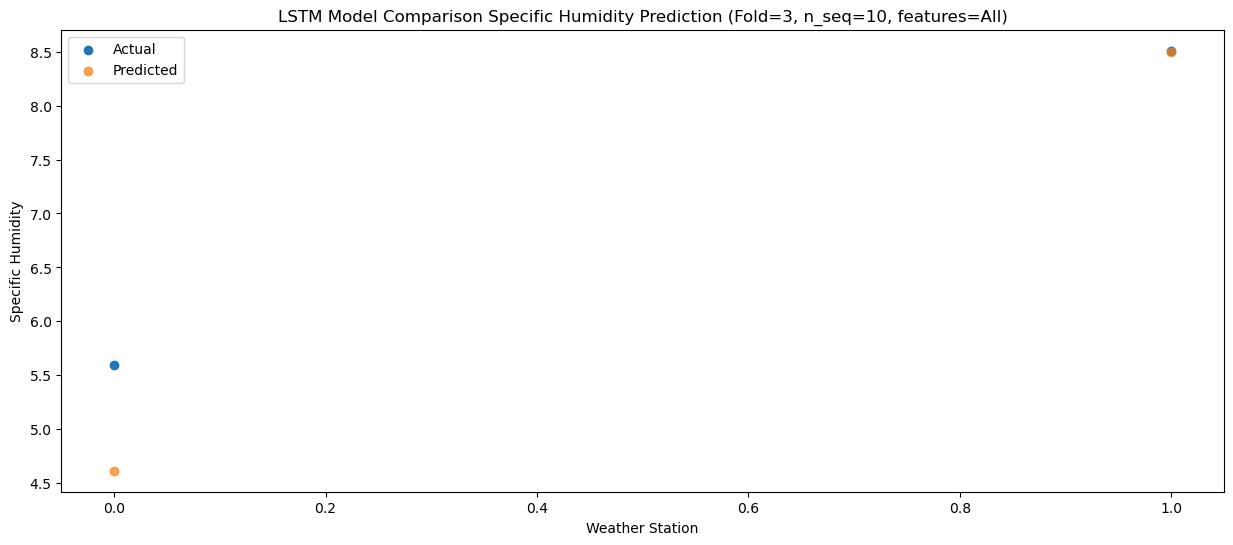

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   4.938778
1                1    8.87   8.818779


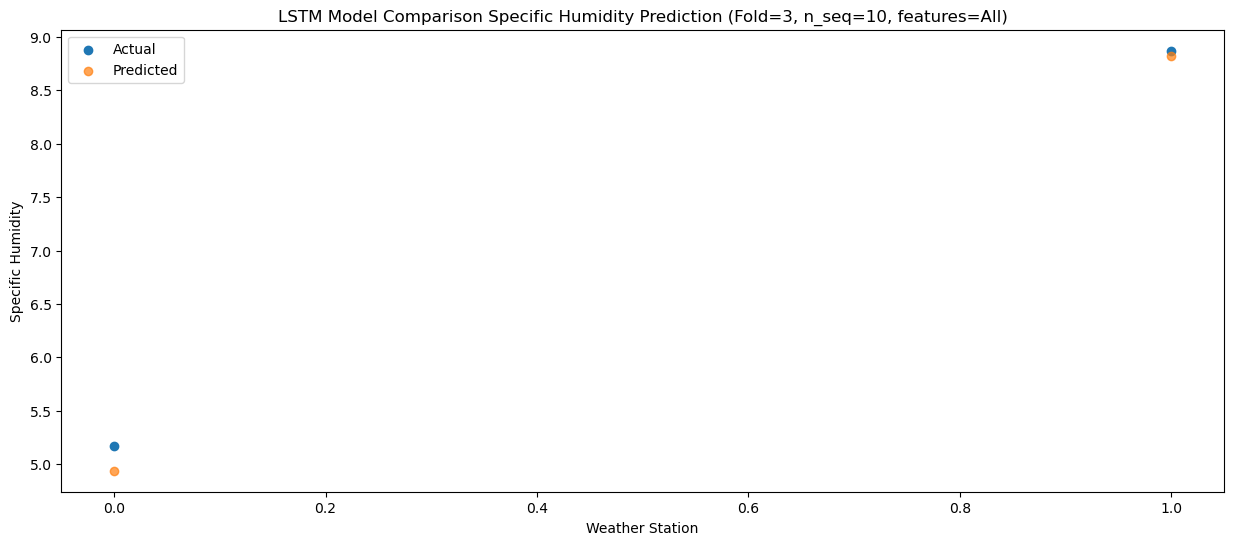

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.427618
1                1    8.75   8.307619


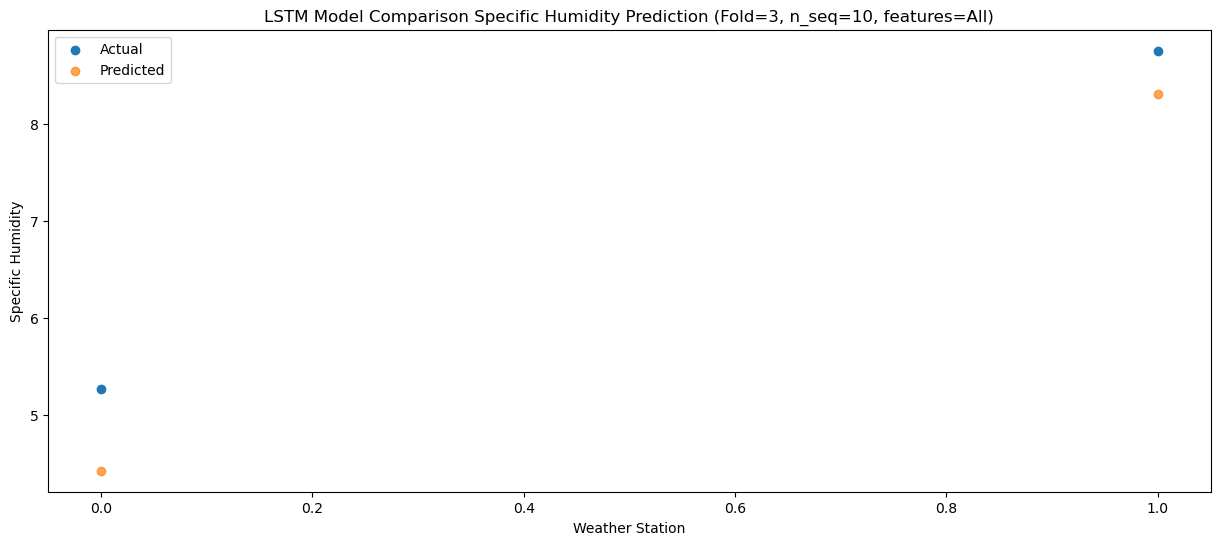

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.318894
1                1    8.66   8.198894


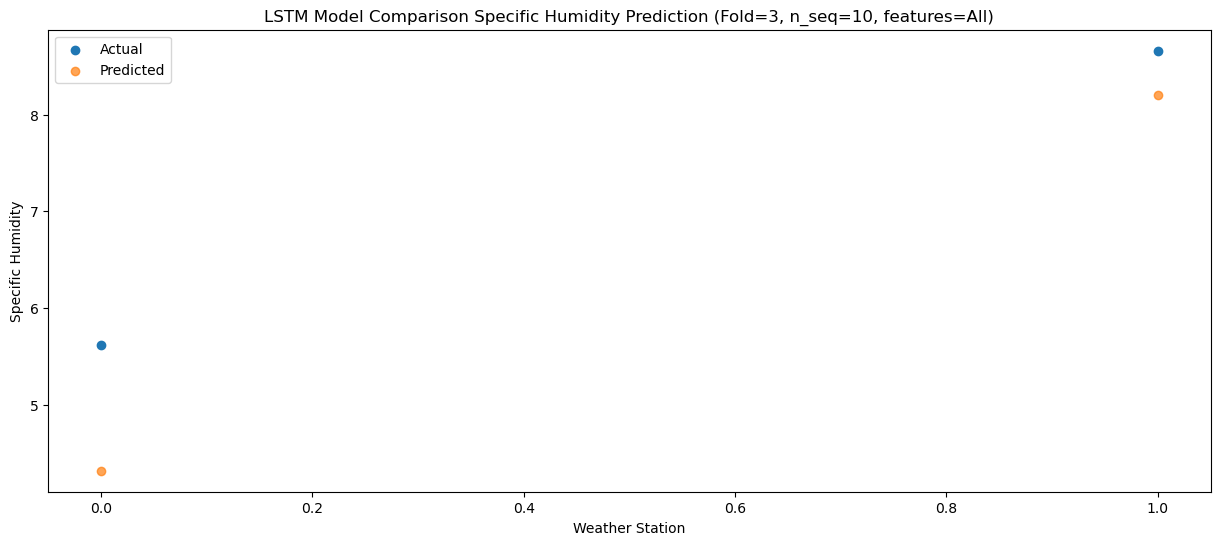

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.746273
1                1    8.63   8.626274


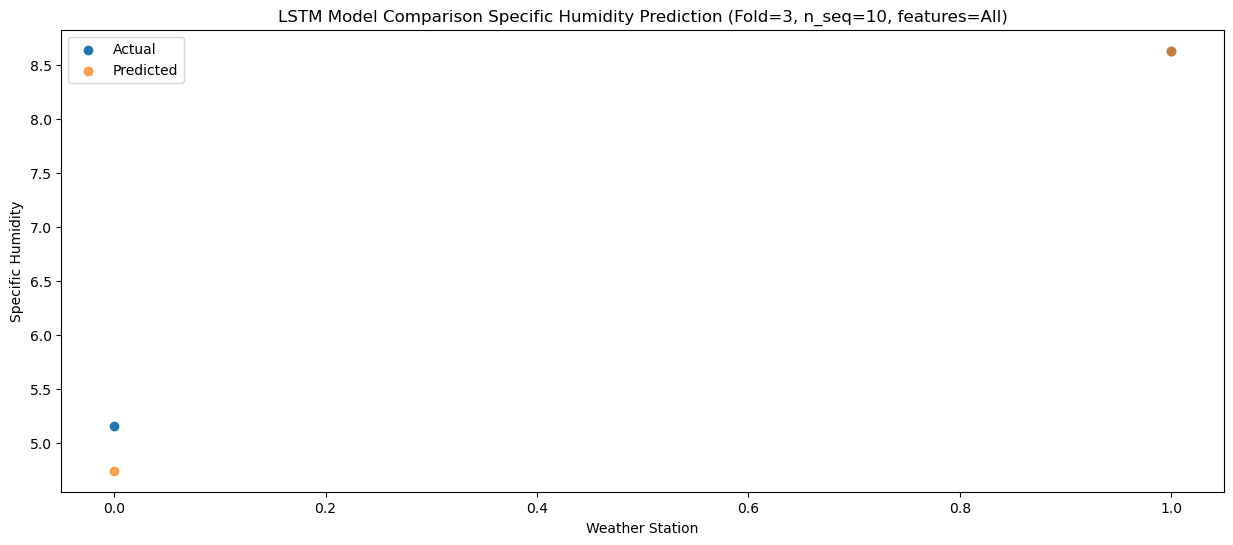

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.454396
1                1    8.16   8.334397


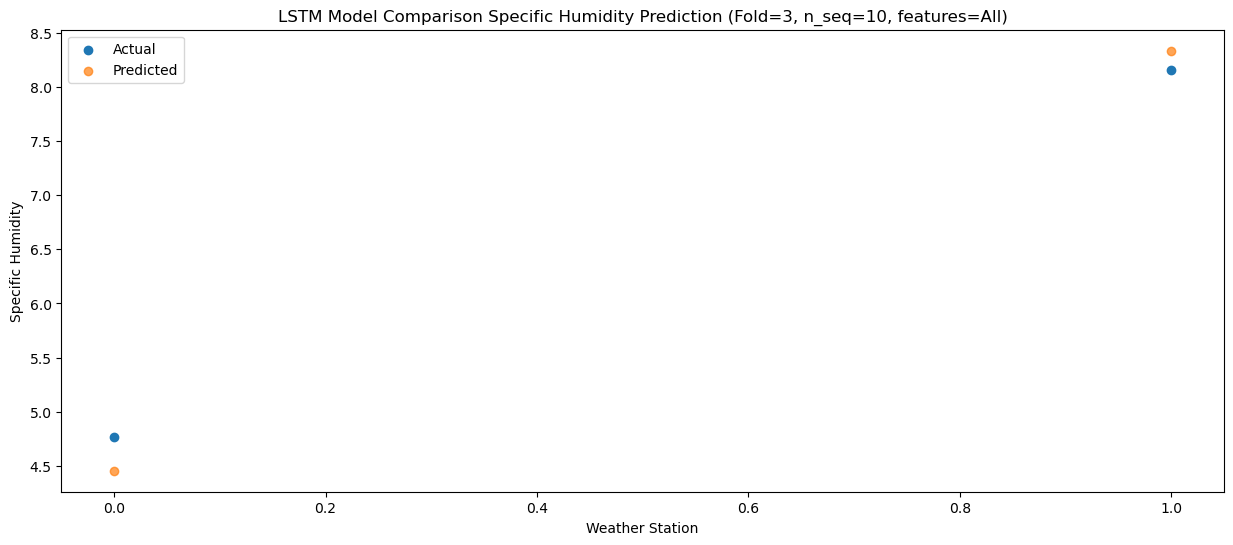

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.589723
1                1    8.18   8.469723


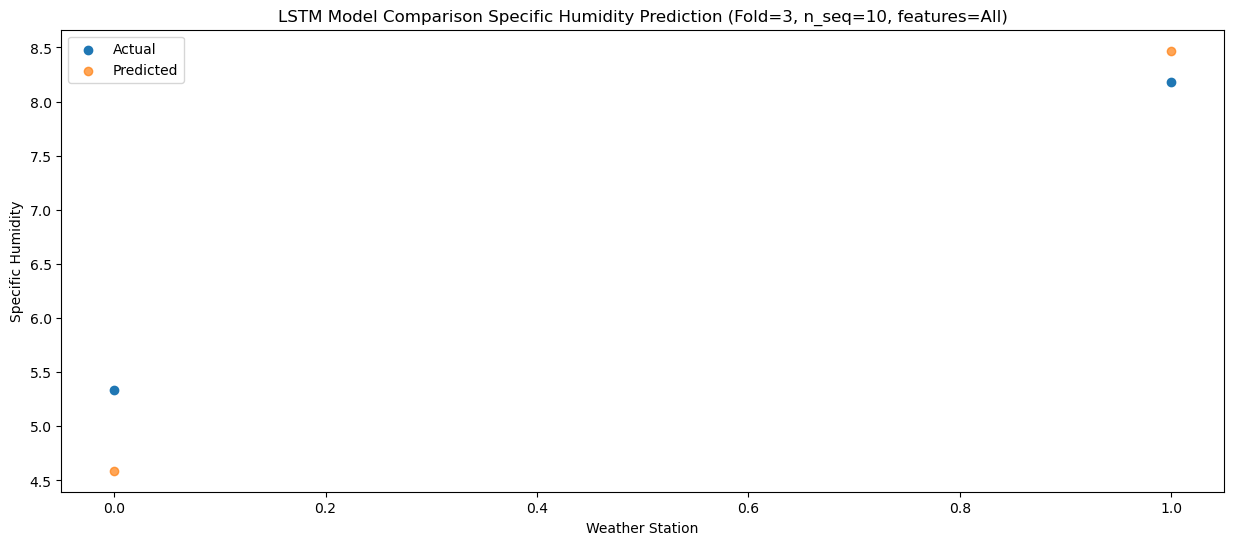

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.3835236  8.2635236 ]
 [4.52230987 8.40231027]
 [4.81297257 8.69297336]
 [4.61376773 8.49376851]
 [4.93877776 8.81877855]
 [4.42761792 8.30761853]
 [4.31889353 8.19889395]
 [4.74627347 8.62627427]
 [4.45439599 8.3343968 ]
 [4.589723   8.46972321]]
Year at t+1:
t+1 SKRMSE: 0.439377
t+1 KRMSE: 0.439377
t+1 MAE: 0.425000
t+1 SKMAPE: 0.074238
t+1 R2_SCORE: 0.915890
t+1 KMAPE: 0.074238
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.429507
t+2 KRMSE: 0.429507
t+2 MAE: 0.382690
t+2 SKMAPE: 0.067561
t+2 R2_SCORE: 0.939417
t+2 KMAPE: 0.067561
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.089847
t+3 KRMSE: 0.089847
t+3 MAE: 0.065000
t+3 SKMAPE: 0.013028
t+3 R2_SCORE: 0.997704
t+3 KMAPE: 0.013028
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.690396
t+4 KRMSE: 0.6903

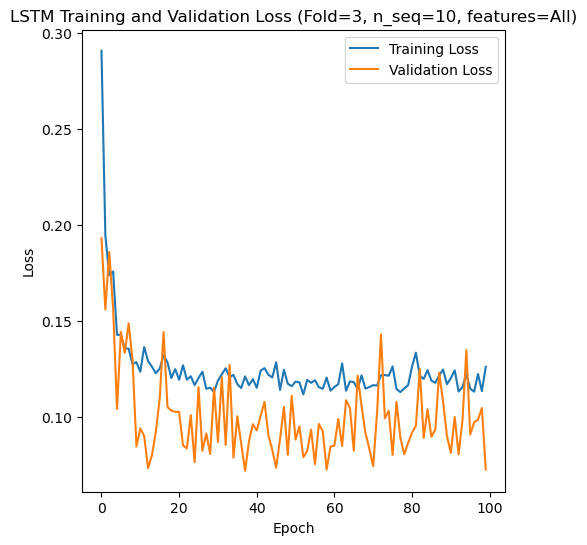

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 22s 328ms/step - loss: 0.2654 - accuracy: 0.4211 - mae: 0.2281 - rmse: 0.2654 - mape: 53.6292 - pearson: 0.1115 - val_loss: 0.2328 - val_accuracy: 0.0000e+00 - val_mae: 0.1977 - val_rmse: 0.2328 - val_mape: 45.0932 - val_pearson: 0.0403
Epoch 2/100
19/19 [==============================] - 1s 67ms/step - loss: 0.1408 - accuracy: 0.1579 - mae: 0.1176 - rmse: 0.1408 - mape: 28.0679 - pearson: 0.1416 - val_loss: 0.1181 - val_accuracy: 0.0000e+00 - val_mae: 0.0942 - val_rmse: 0.1181 - val_mape: 21.6644 - val_pearson: 0.0583
Epoch 3/100
19/19 [==============================] - 1s 66ms/step - loss: 0.1398 - a

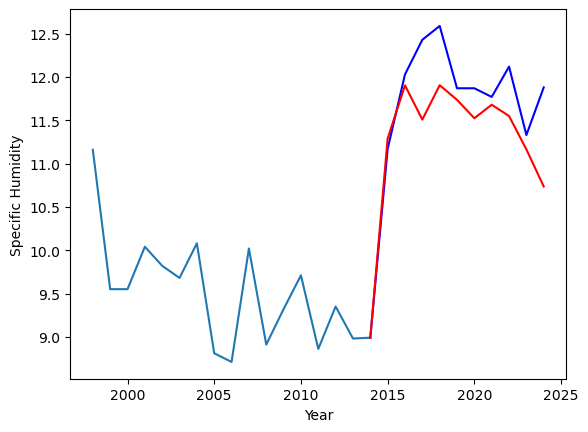

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		8.46		0.39
8.73		9.07		0.34
9.20		8.68		-0.52
8.87		9.08		0.21
9.27		8.91		-0.36
8.73		8.69		-0.04
8.46		8.85		0.39
8.79		8.72		-0.07
8.19		8.33		0.14
8.42		7.91		-0.51


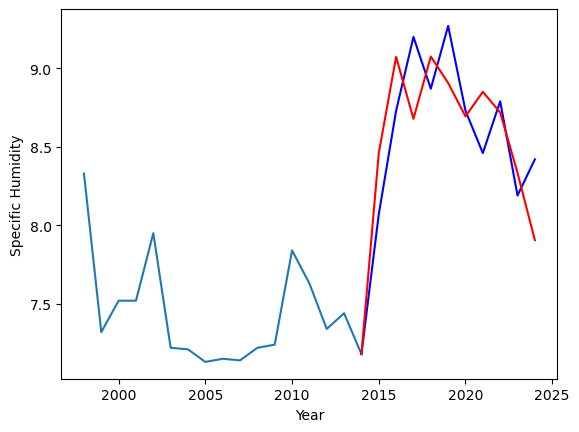

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  11.290138
1                1    8.07   8.460138


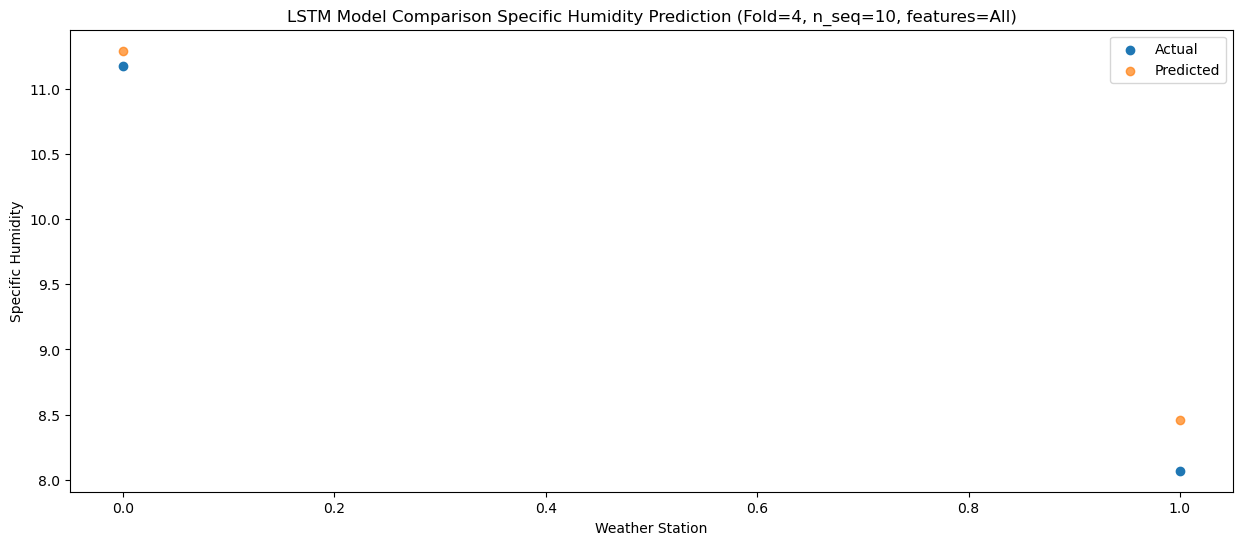

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03   11.90325
1                1    8.73    9.07325


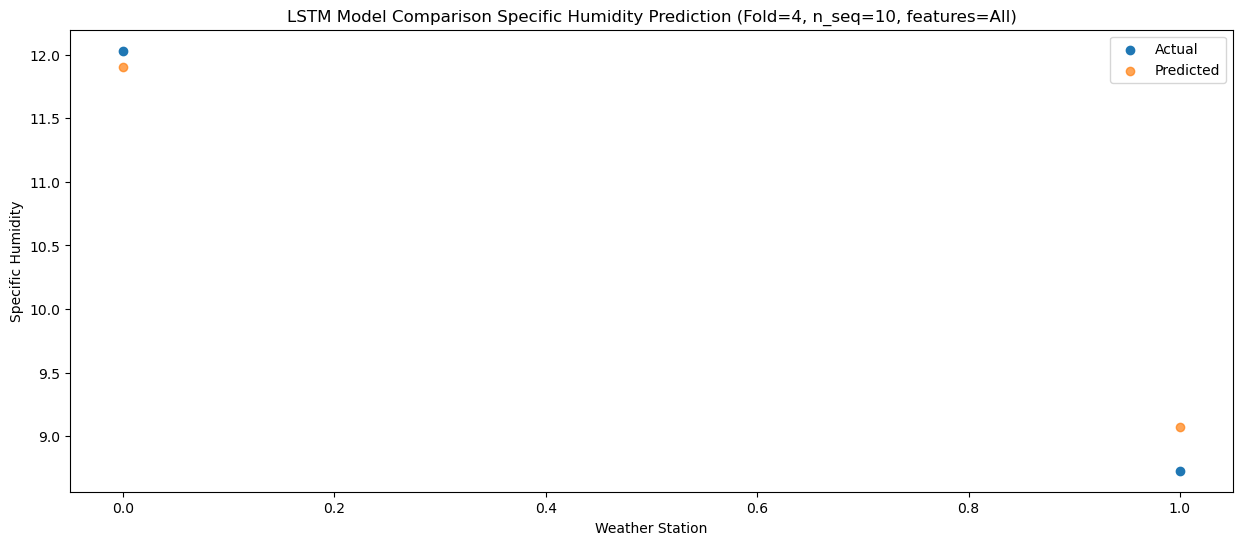

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.508439
1                1    9.20   8.678439


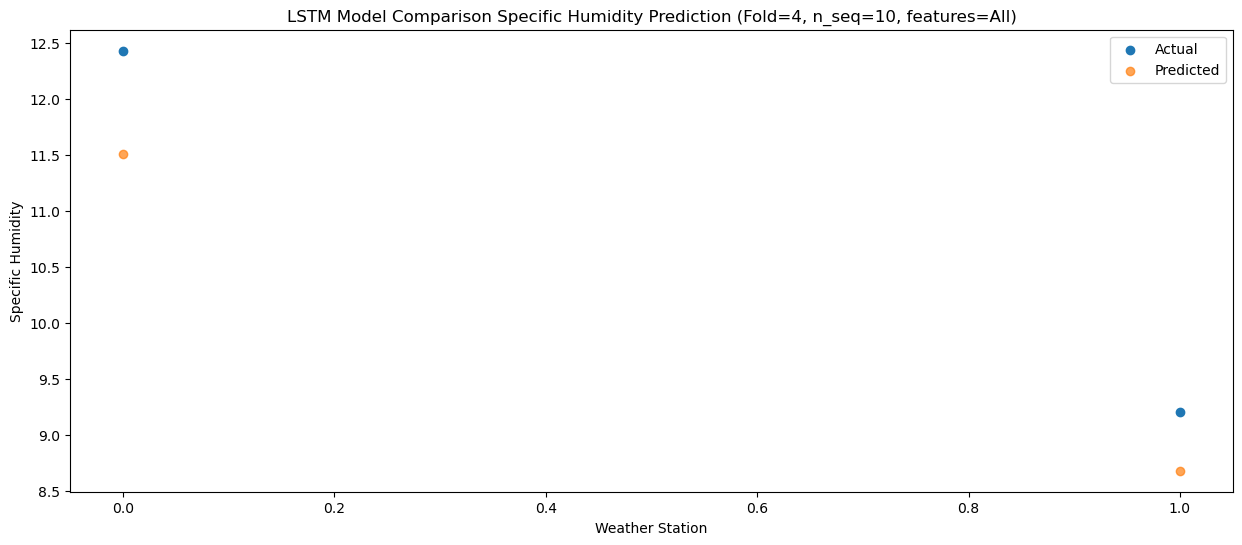

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.905359
1                1    8.87   9.075359


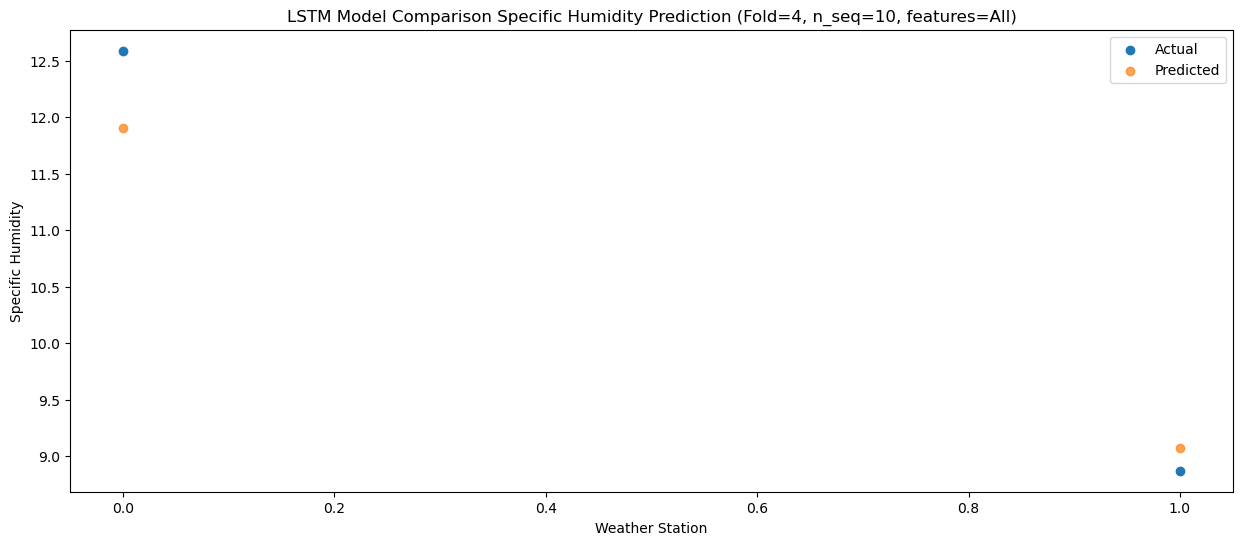

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.736643
1                1    9.27   8.906642


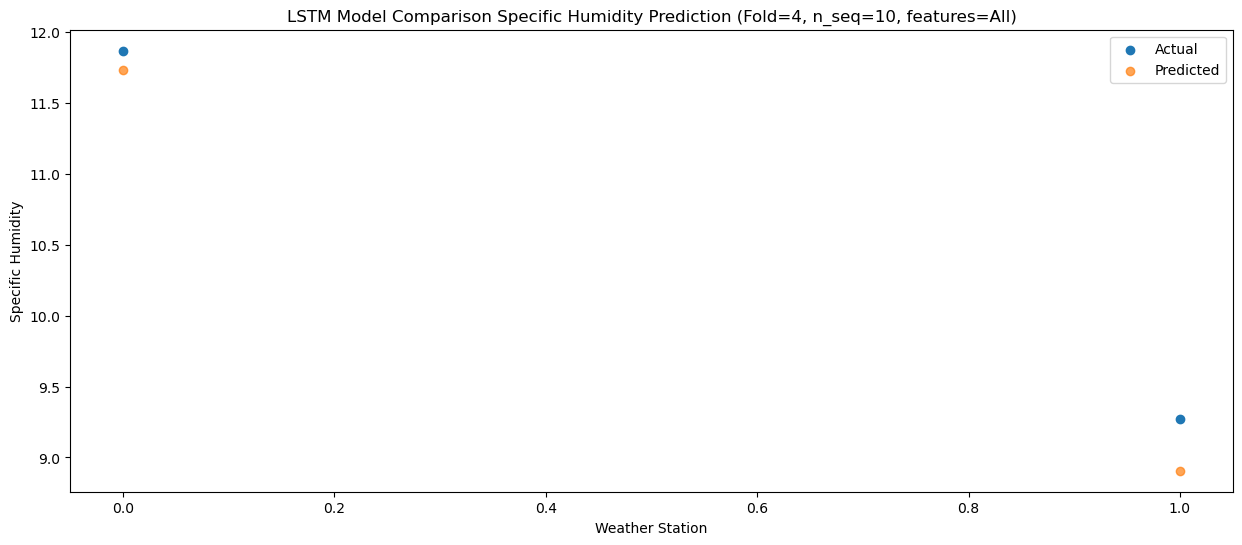

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.523844
1                1    8.73   8.693844


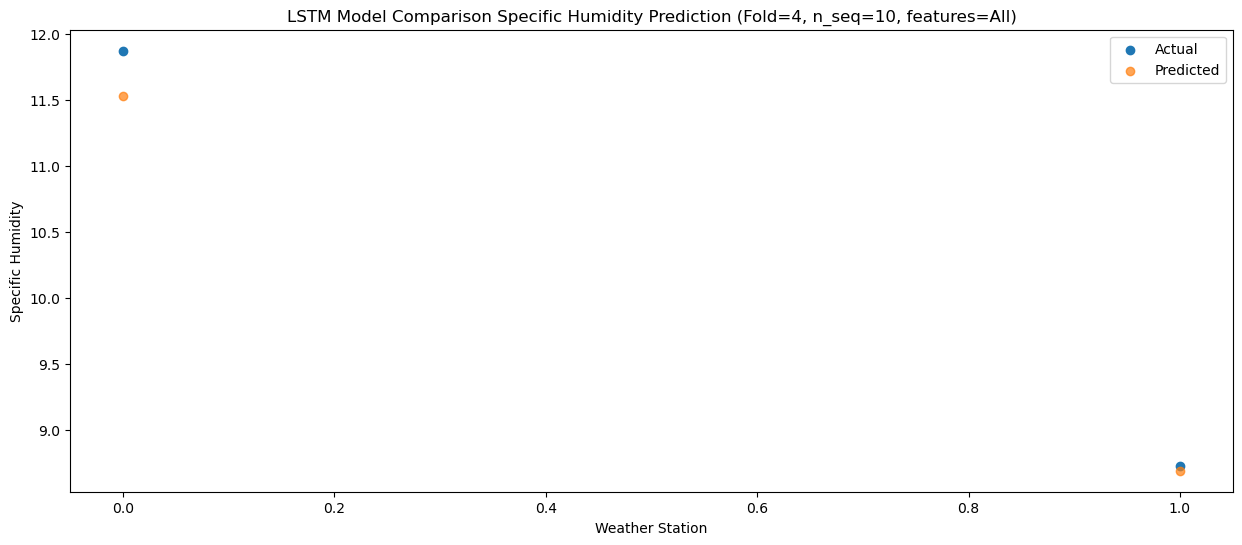

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.680067
1                1    8.46   8.850067


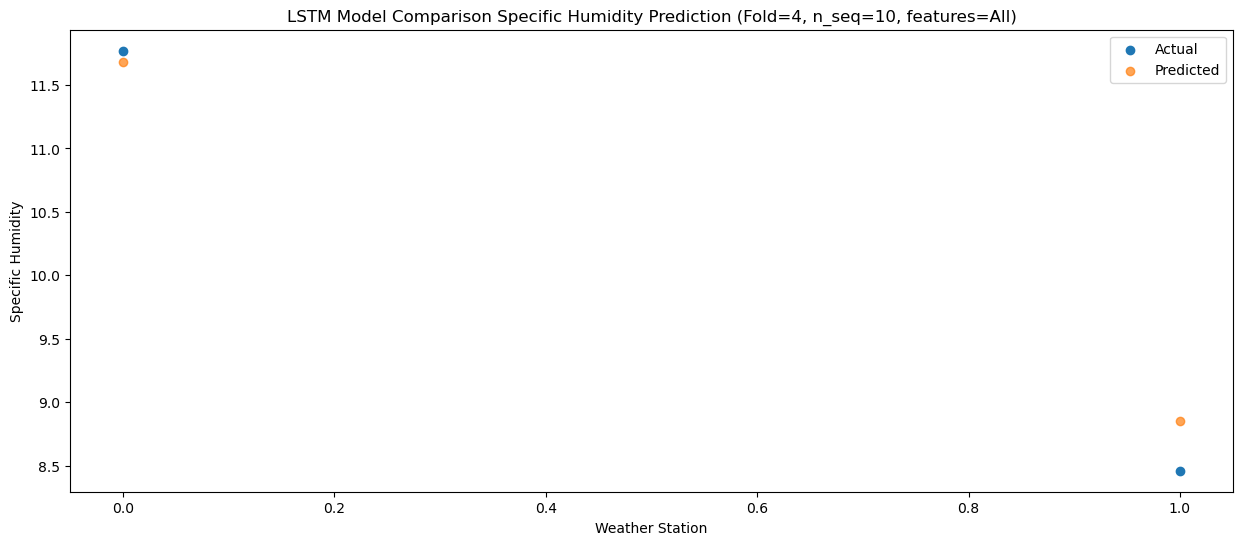

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.549329
1                1    8.79   8.719329


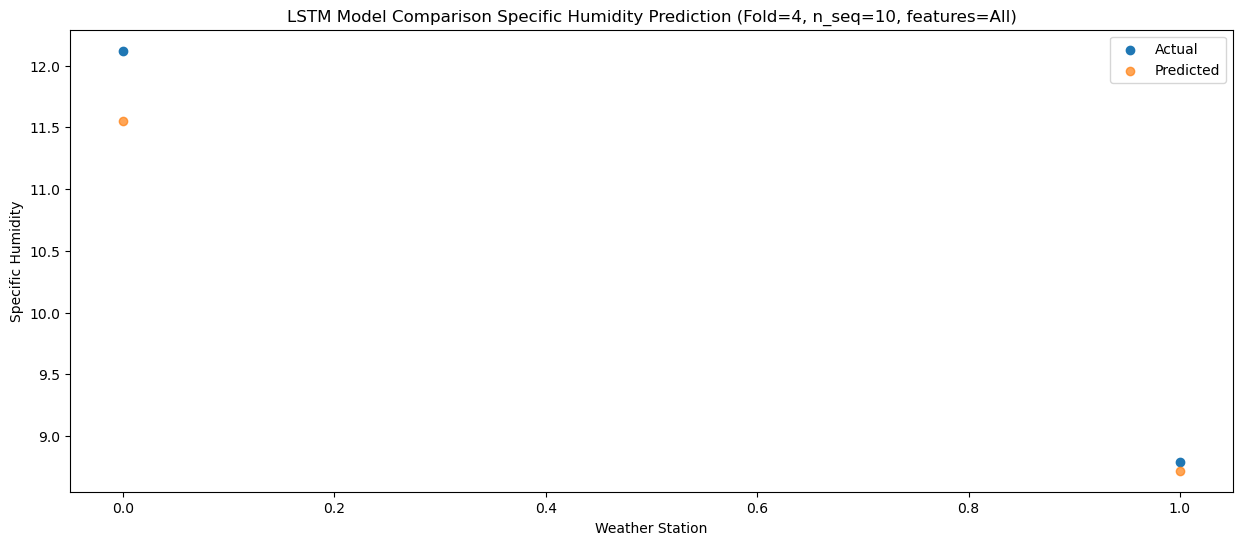

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.164161
1                1    8.19   8.334161


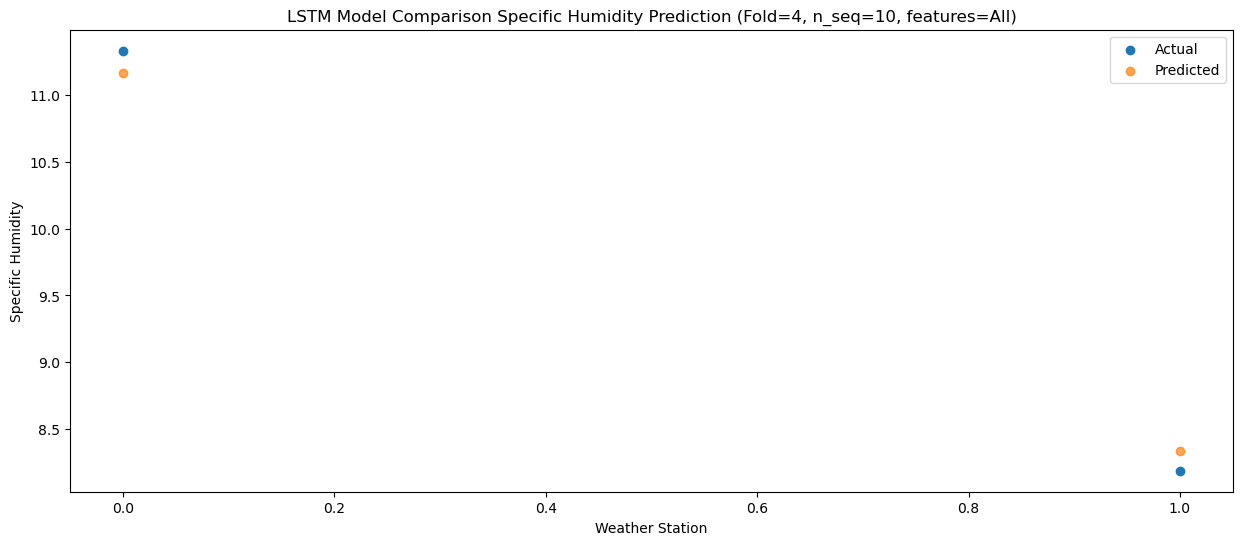

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  10.735765
1                1    8.42   7.905765


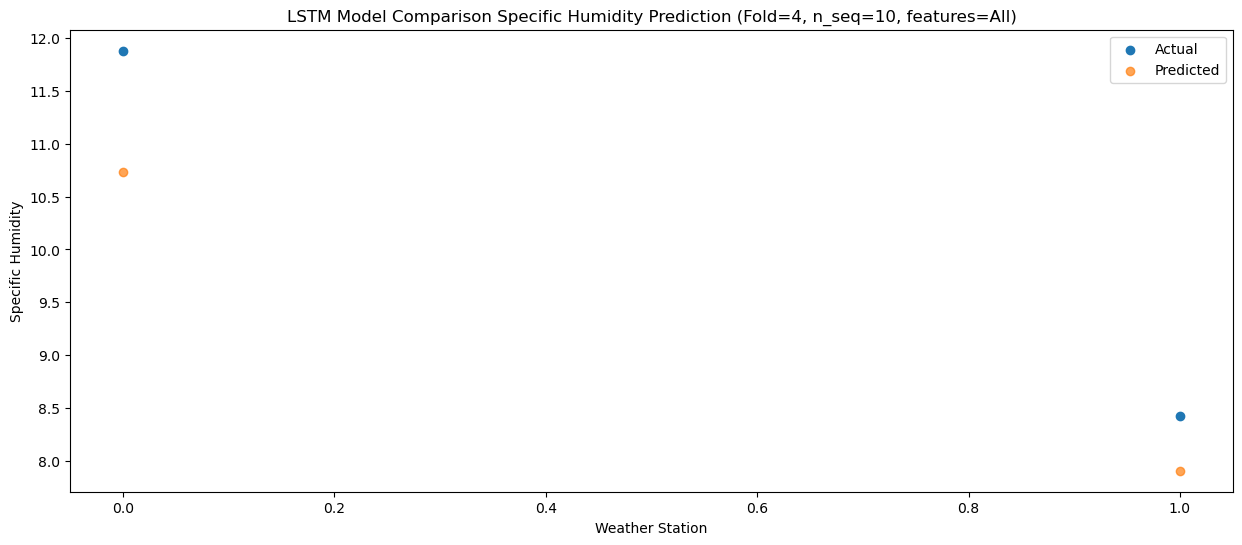

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[11.29013813  8.46013813]
 [11.90324951  9.07324951]
 [11.50843937  8.67843937]
 [11.905359    9.07535927]
 [11.73664265  8.9066425 ]
 [11.5238439   8.69384362]
 [11.68006702  8.85006701]
 [11.54932937  8.71932936]
 [11.16416064  8.33416063]
 [10.73576489  7.90576473]]
Year at t+1:
t+1 SKRMSE: 0.288653
t+1 KRMSE: 0.288653
t+1 MAE: 0.255138
t+1 SKMAPE: 0.029550
t+1 R2_SCORE: 0.965319
t+1 KMAPE: 0.029550
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.258733
t+2 KRMSE: 0.258733
t+2 MAE: 0.235000
t+2 SKMAPE: 0.024927
t+2 R2_SCORE: 0.975411
t+2 KMAPE: 0.024927
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.748765
t+3 KRMSE: 0.748765
t+3 MAE: 0.721561
t+3 SKMAPE: 0.065416
t+3 R2_SCORE: 0.785045
t+3 KMAPE: 0.065416
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

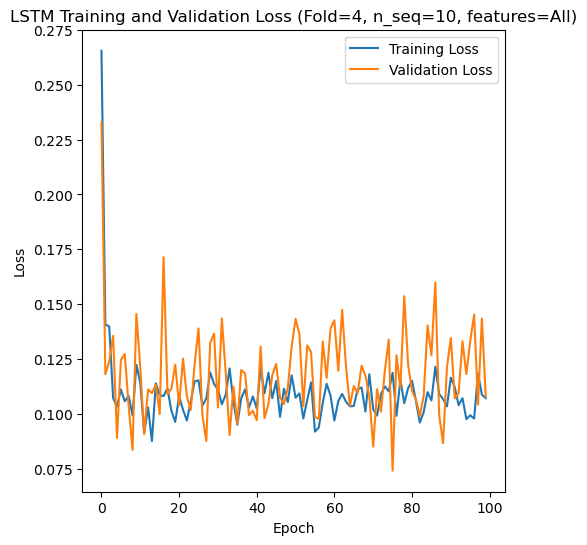

[[0.5805966654505069], [1.0931566968225945], [0.5326649185128486], [0.5262816221099555], [0.4645736017841335]]
[[array(0.58059667)], [array(1.0931567)], [array(0.53266492)], [array(0.52628162)], [array(0.4645736)]]
[[0.4628733319044109], [0.9466763844024385], [0.43432637561112586], [0.4007358722388745], [0.3641118369400499]]
[[0.04026928649313015], [0.09465884459421275], [0.04776010997343372], [0.06879648626372398], [0.03497773868289682]]
[[0.8588097100404731], [0.6724087430726577], [0.762770866226389], [0.9016350558047953], [0.9220267989284686]]
[[array(0.04026929)], [array(0.09465884)], [array(0.04776011)], [array(0.06879649)], [array(0.03497774)]]
[[array(0.94544339)], [array(0.91847485)], [array(0.87346117)], [array(0.96988037)], [array(0.94683874)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8.26  7.

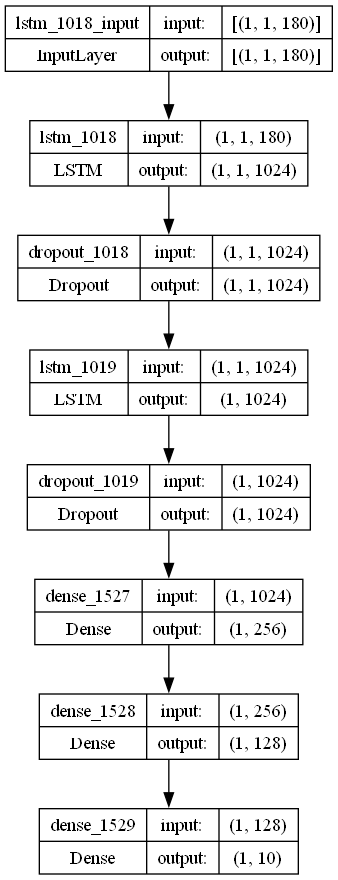

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.006360634940219467
    optimizer = Adam(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 1024
    dropout_rate = 0.3103677591929867

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S10.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)